In this context cross partitioning:
    selecting genomes for training and testing (instead of gene like Supervised.ipynb)
Done:
- created a function called ml_load_species_folds
    - this returns the 6 folds
- I think I need to edit the MLClassifier to hold the metrics for eval (object attribute):
    - This is to caclulacte precision of the CV
    - Brush up on how to calculate
- Used class weights
    - for hold out cv
    - and for 6 fold cv
- edit dataloader for DL method
    - Holdout
    - 6-fold
- created a function for cv for dl


TODO:
- data_loader still not able to load data type A.. need to solve it
    - in Josefa's code functio code is not reliable so for now no need



In [1]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from collections import Counter
import numpy as np

from utils.machine_learning.data_loader import ml_load_species, ml_load_species_folds
from utils.machine_learning.trainer import MLClassifier, ml_trainer, ml_cross_validator

In [2]:
X_B_train, y_B_train = ml_load_species('all', 'B', 'train', drop_na=True)
X_B_test, y_B_test = ml_load_species('all', 'B', 'test', drop_na=True)
X_C_train, y_C_train = ml_load_species('all', 'C', 'train', drop_na=True)
X_C_test, y_C_test = ml_load_species('all', 'C', 'test', drop_na=True)
X_D_train, y_D_train = ml_load_species('all', 'D', 'train', drop_na=True)
X_D_test, y_D_test = ml_load_species('all', 'D', 'test', drop_na=True)
X_E_train, y_E_train = ml_load_species('all', 'E', 'train', drop_na=True)
X_E_test, y_E_test = ml_load_species('all', 'E', 'test', drop_na=True)
print(X_B_train.shape)
print(X_B_test.shape)
print(X_C_train.shape)
print(X_C_test.shape)
print(X_D_train.shape)
print(X_D_test.shape)
print(X_E_train.shape)
print(X_E_test.shape)

(133080, 12)
(62102, 12)
(133084, 10)
(62102, 10)
(133084, 4)
(62102, 4)
(133080, 8)
(62102, 8)


sample weights based on inverse number of sample

In [18]:
def get_weights(train_set, type='INS'):
    counts = np.unique(y_B_train, return_counts=True)
    sample_weights = []
    
    for i in train_set:
        if i == 0:
            sample_weights.append(1/counts[1][0])
        elif i == 1:
            sample_weights.append(1/counts[1][1])
            
    return sample_weights

In [19]:
print(np.unique(y_B_train, return_counts=True))
print(np.unique(y_C_train, return_counts=True))
print(np.unique(y_D_train, return_counts=True))
print(np.unique(y_E_train, return_counts=True))

(array([0., 1.]), array([122997,  10083]))
(array([0., 1.]), array([123001,  10083]))
(array([0., 1.]), array([123001,  10083]))
(array([0., 1.]), array([122997,  10083]))


In [20]:
sample_weights_B = get_weights(y_B_train)
sample_weights_C = get_weights(y_C_train)
sample_weights_D = get_weights(y_D_train)
sample_weights_E = get_weights(y_E_train)

In [4]:
X_B_train[0]

array([ 0.000e+00,  5.700e+02,  2.250e+01, -2.500e+00,  2.770e+01,
       -1.000e-01,  1.880e+01, -7.000e-01,  2.300e+01, -1.600e+00,
        1.496e+02,  1.000e+00])

In [5]:
(X_B_fold1, y_B_fold1), (X_B_fold2, y_B_fold2), (X_B_fold3, y_B_fold3), (X_B_fold4, y_B_fold4), (X_B_fold5, y_B_fold5), (X_B_fold6, y_B_fold6) = ml_load_species_folds( 'B', drop_na=True)
(X_C_fold1, y_C_fold1), (X_C_fold2, y_C_fold2), (X_C_fold3, y_C_fold3), (X_C_fold4, y_C_fold4), (X_C_fold5, y_C_fold5), (X_C_fold6, y_C_fold6) = ml_load_species_folds( 'C', drop_na=True)
(X_D_fold1, y_D_fold1), (X_D_fold2, y_D_fold2), (X_D_fold3, y_D_fold3), (X_D_fold4, y_D_fold4), (X_D_fold5, y_D_fold5), (X_D_fold6, y_D_fold6) = ml_load_species_folds( 'D', drop_na=True)
(X_E_fold1, y_E_fold1), (X_E_fold2, y_E_fold2), (X_E_fold3, y_E_fold3), (X_E_fold4, y_E_fold4), (X_E_fold5, y_E_fold5), (X_E_fold6, y_E_fold6) = ml_load_species_folds( 'E', drop_na=True)
print(X_B_fold1.shape)
print(X_C_fold1.shape)
print(X_D_fold1.shape)
print(X_E_fold1.shape)



(38195, 12)
(38195, 10)
(38195, 4)
(38195, 8)


# EDA: How I partitioned the HGTDB for CV

## Distribution of complete DB

Note: depending on which data type you choose (when dropping na), distrbution varies, below is the distribution of data type 'A'
without dropping any nan values

In [6]:
df = ml_load_species('all', 'A', return_df=True, genome_info=True)

<Axes: xlabel='Genome,HGT'>

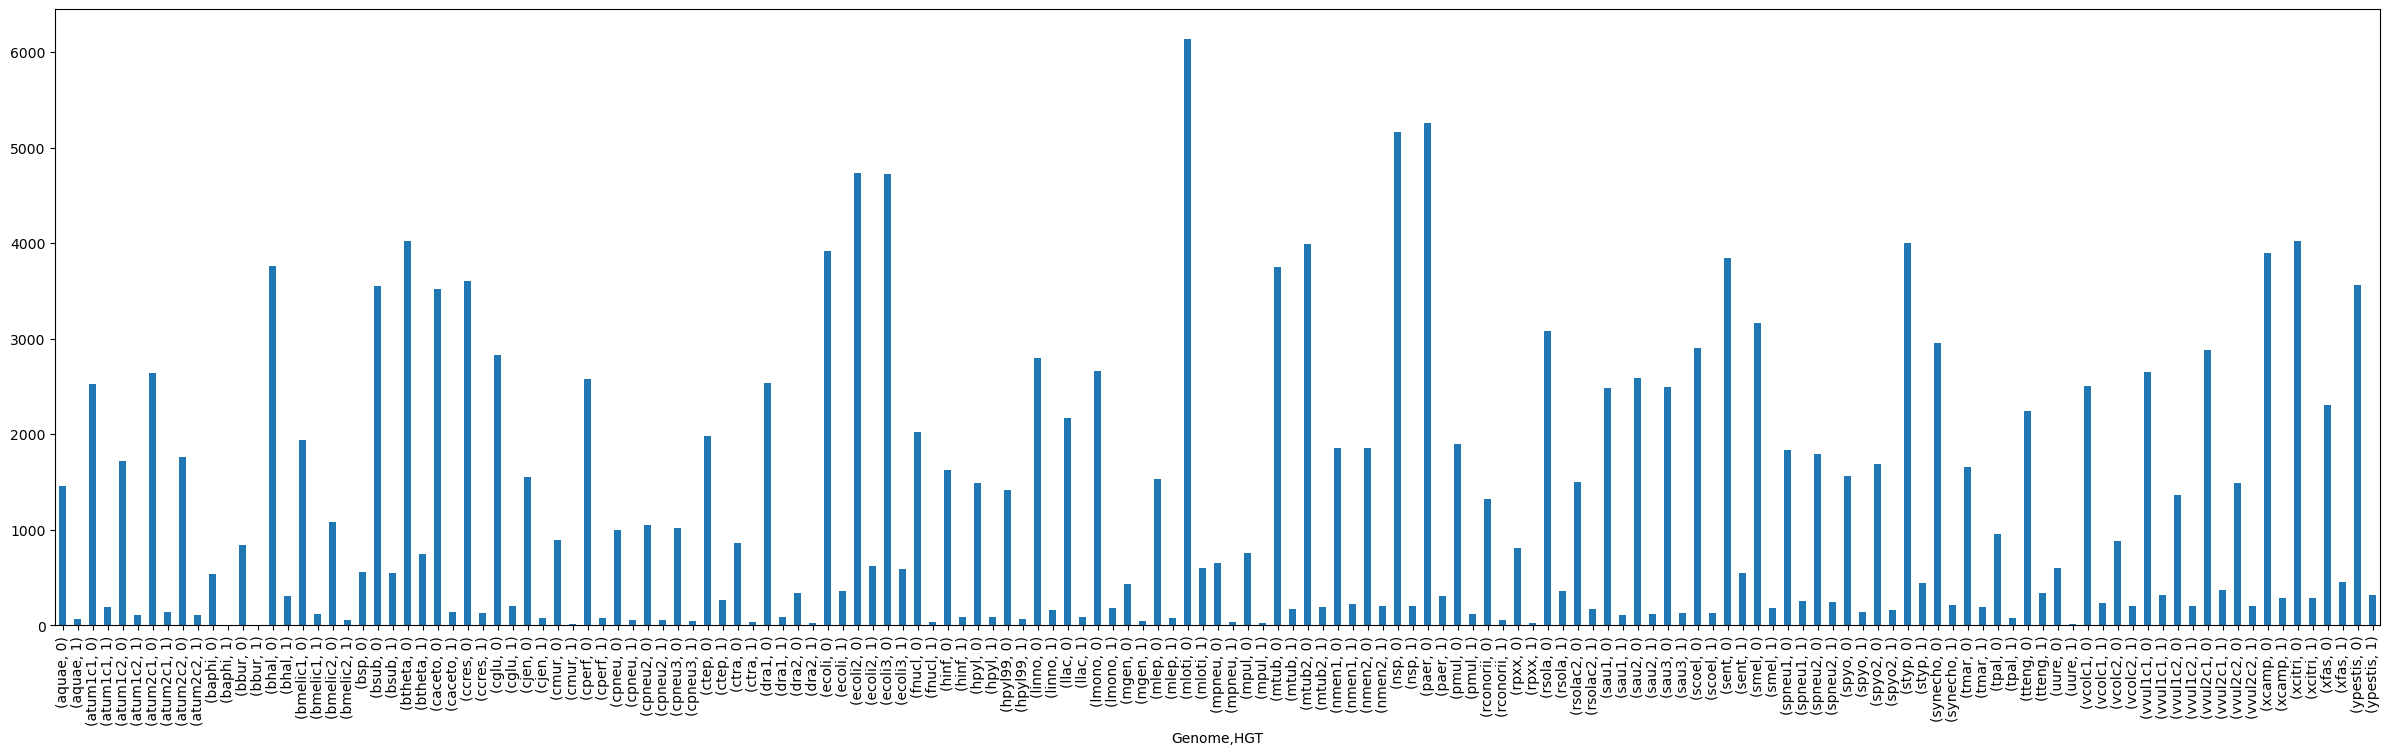

In [7]:
df.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

In [8]:
print(len(df[df['HGT']==0]))
print(len(df[df['HGT']==1]))

180216
14971


## Hold out partitioning

In [9]:
df_holdout_train = ml_load_species('all', 'B',cross_partition='train',drop_na=True,return_df=True, genome_info=True)

<Axes: xlabel='Genome,HGT'>

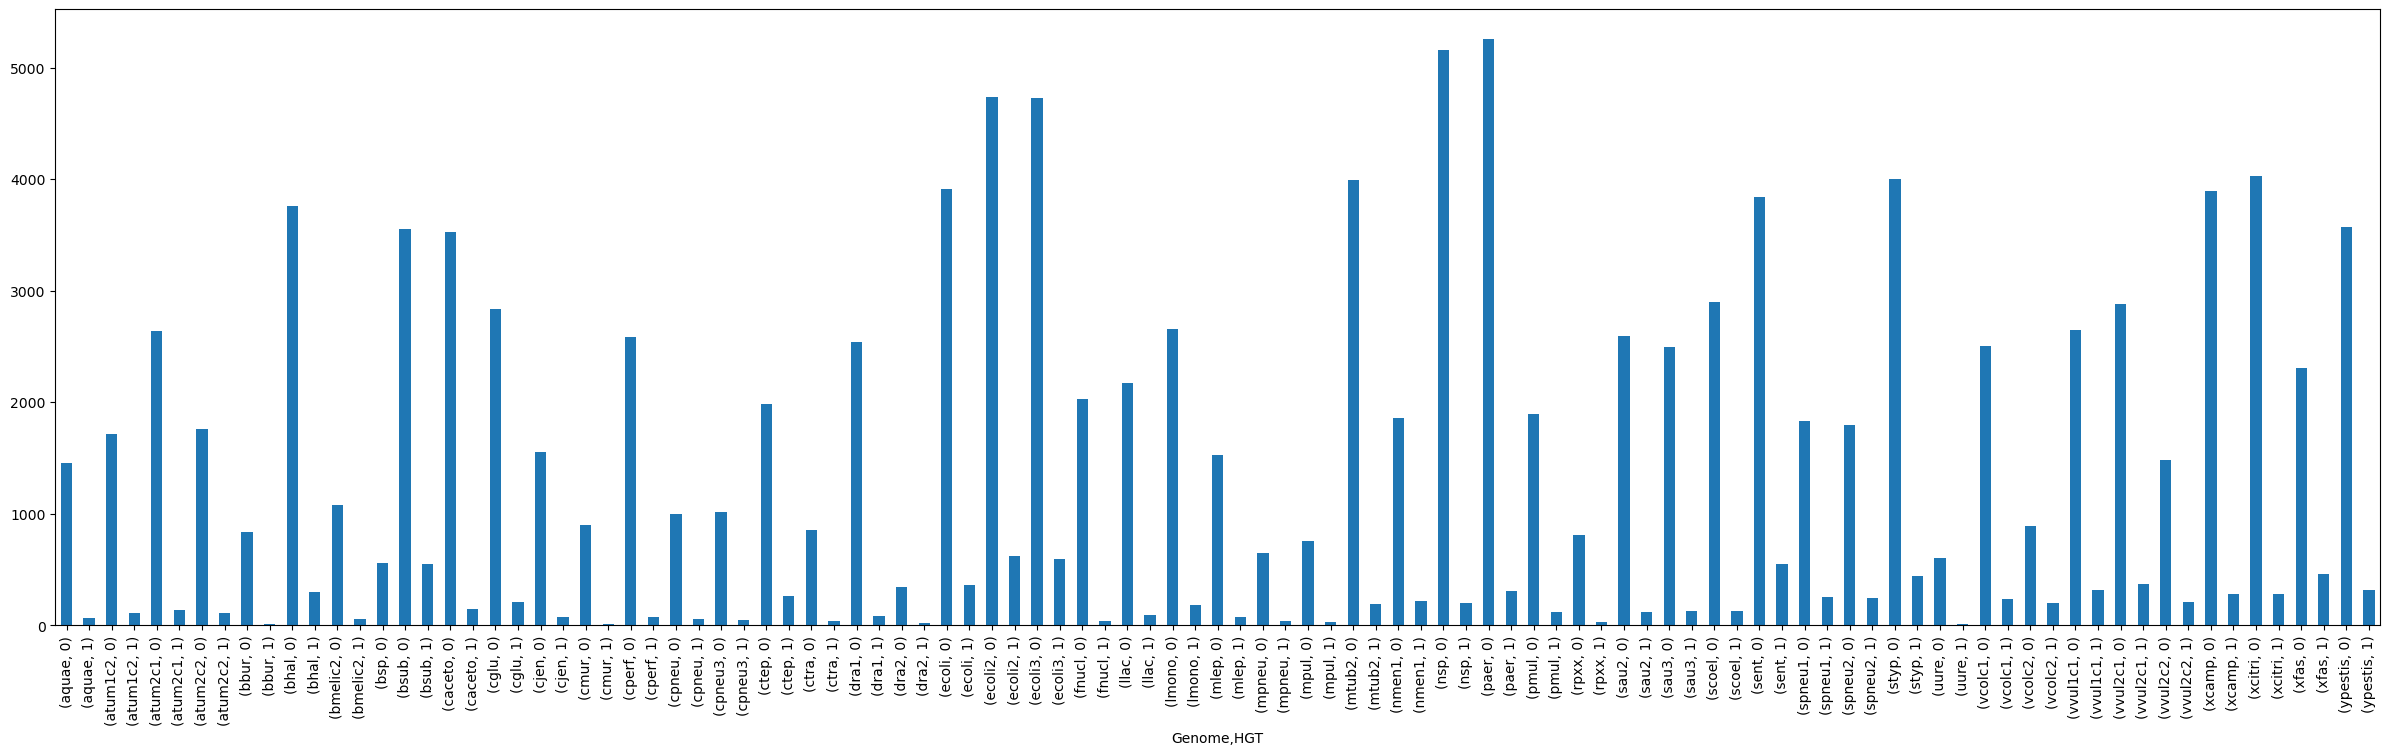

In [10]:
df_holdout_train.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

In [11]:
df_holdout_train['HGT'].count()

133080

In [12]:
df_holdout_test = ml_load_species('all', 'B',cross_partition='test',drop_na=True,return_df=True, genome_info=True)

<Axes: xlabel='Genome,HGT'>

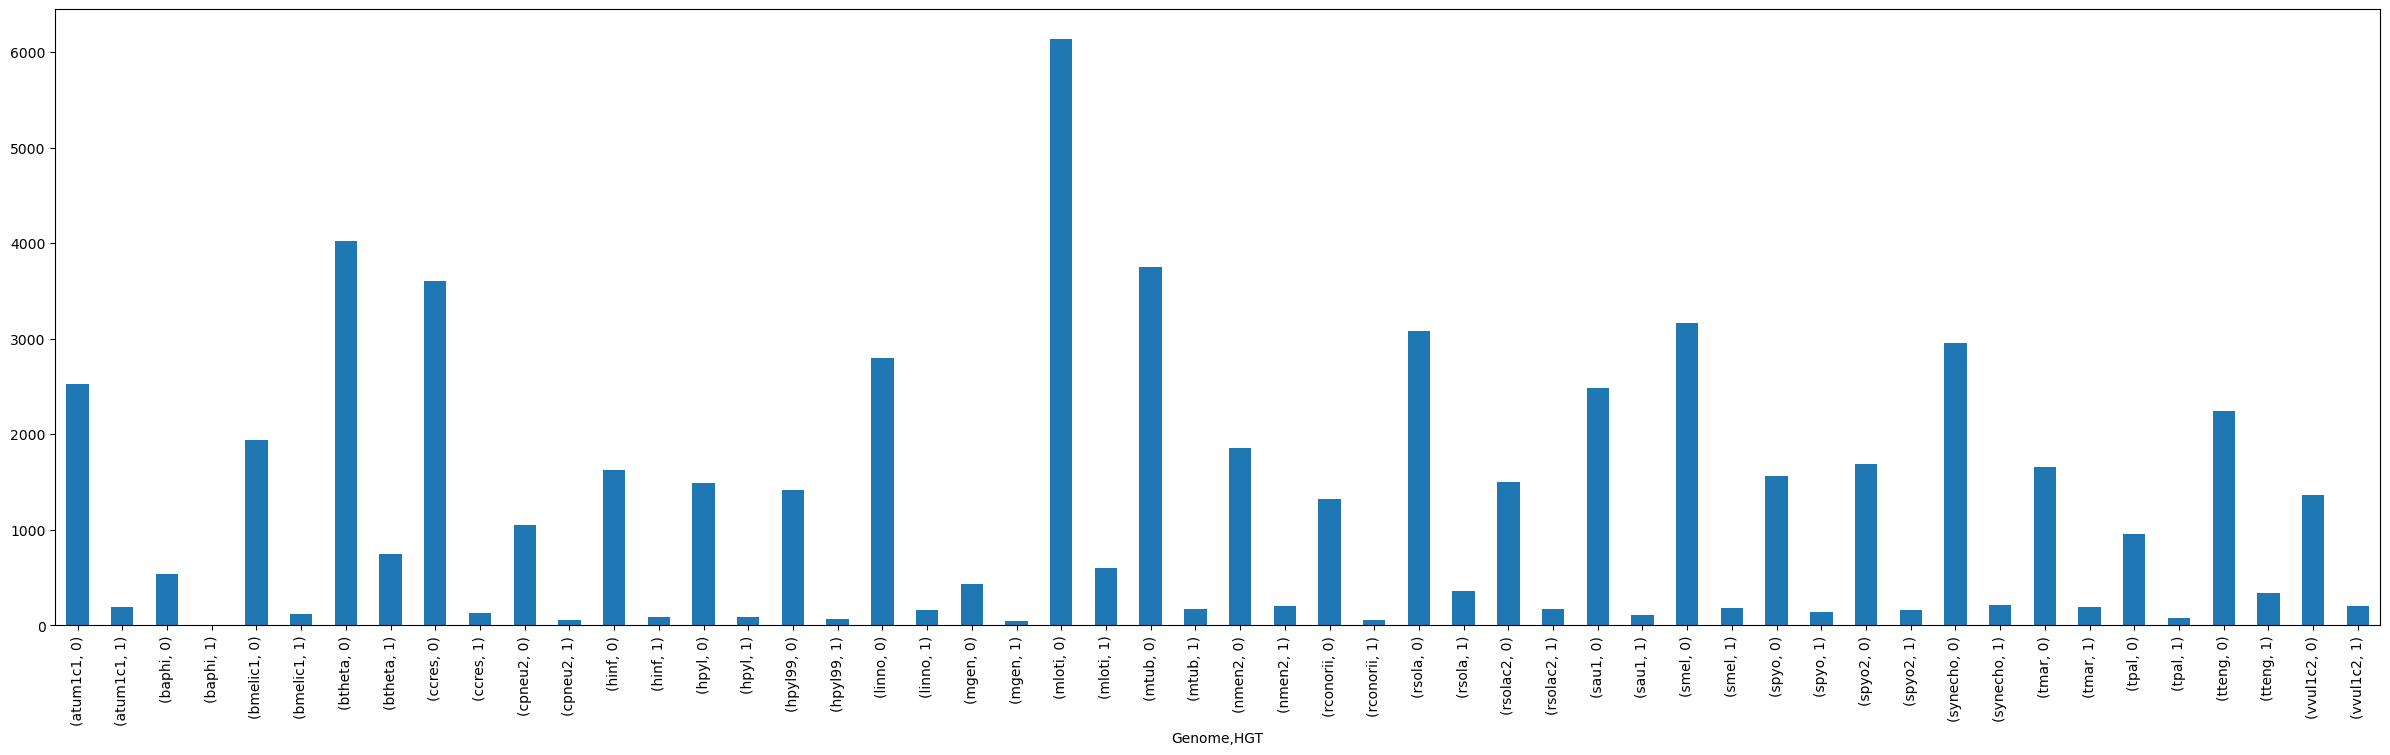

In [13]:
df_holdout_test.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

In [14]:
df_holdout_test['HGT'].count()

62102

## 6-Fold Partitioning

I am really not sure how to stratify them but I guess this works for now

In [15]:
df_fold_1, df_fold_2, df_fold_3, df_fold_4, df_fold_5, df_fold_6 = ml_load_species_folds('B',drop_na=True,return_df=True, genome_info=True)

### Fold 1

<Axes: xlabel='Genome,HGT'>

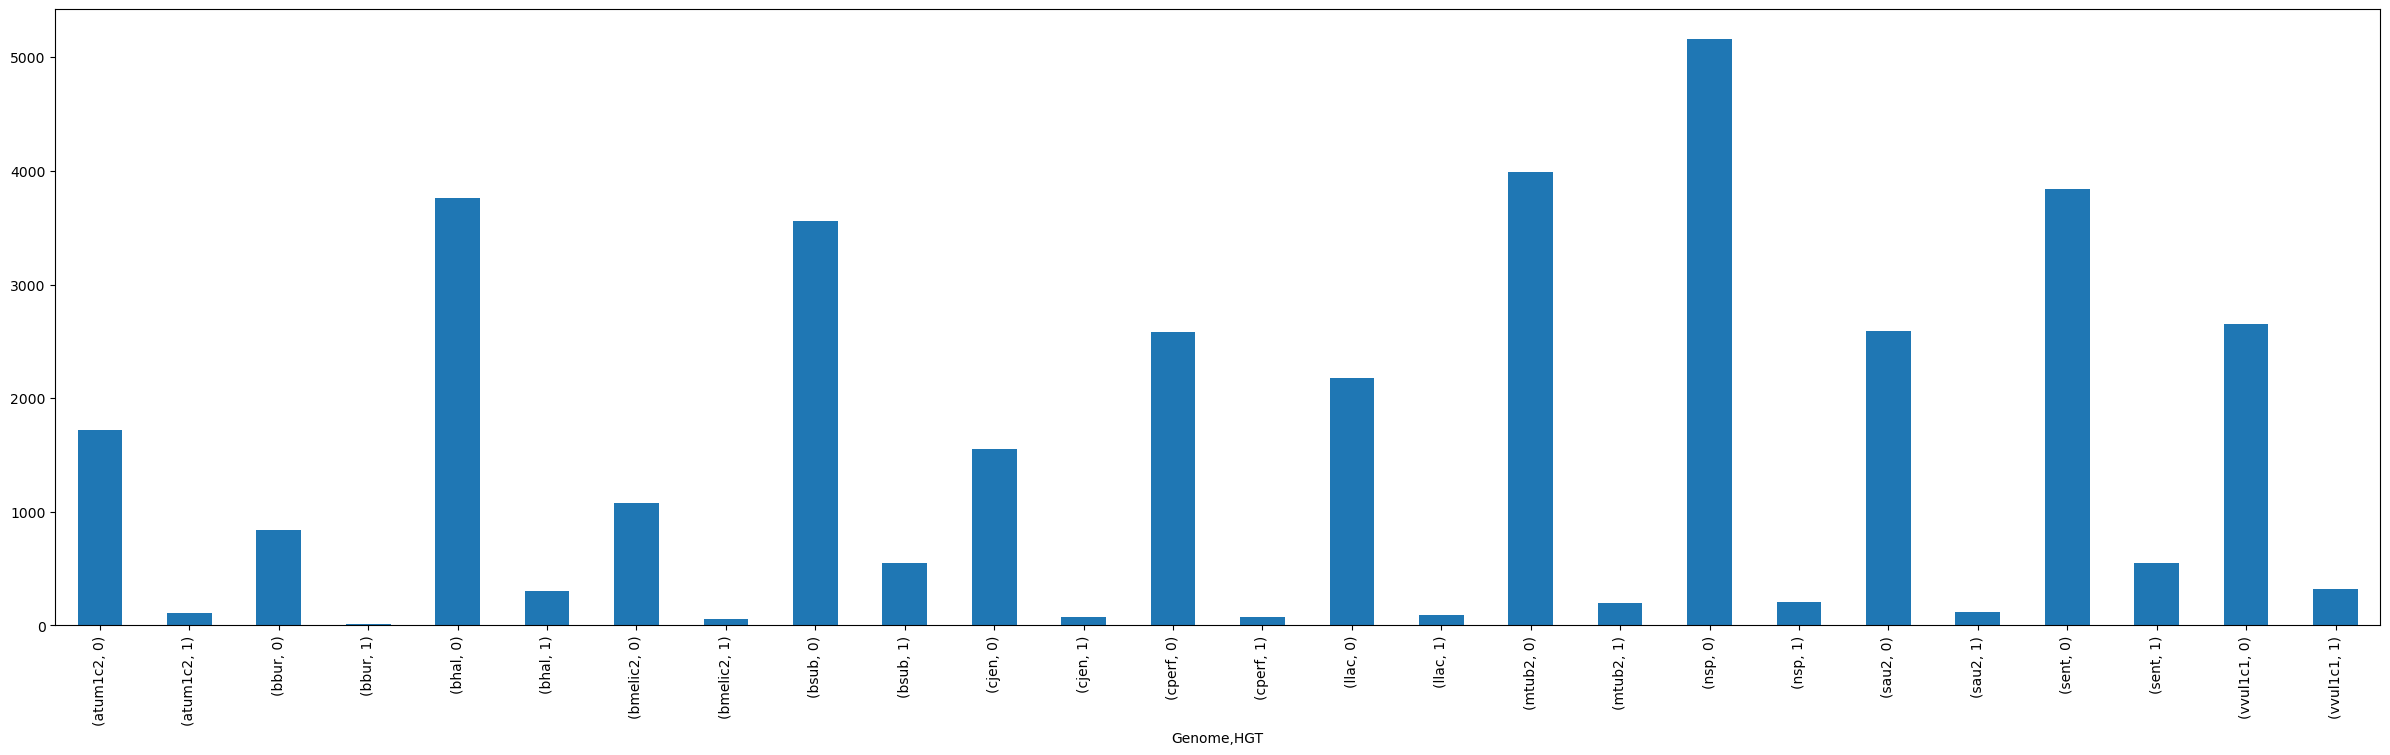

In [16]:
df_fold_1.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

### Fold 2

<Axes: xlabel='Genome,HGT'>

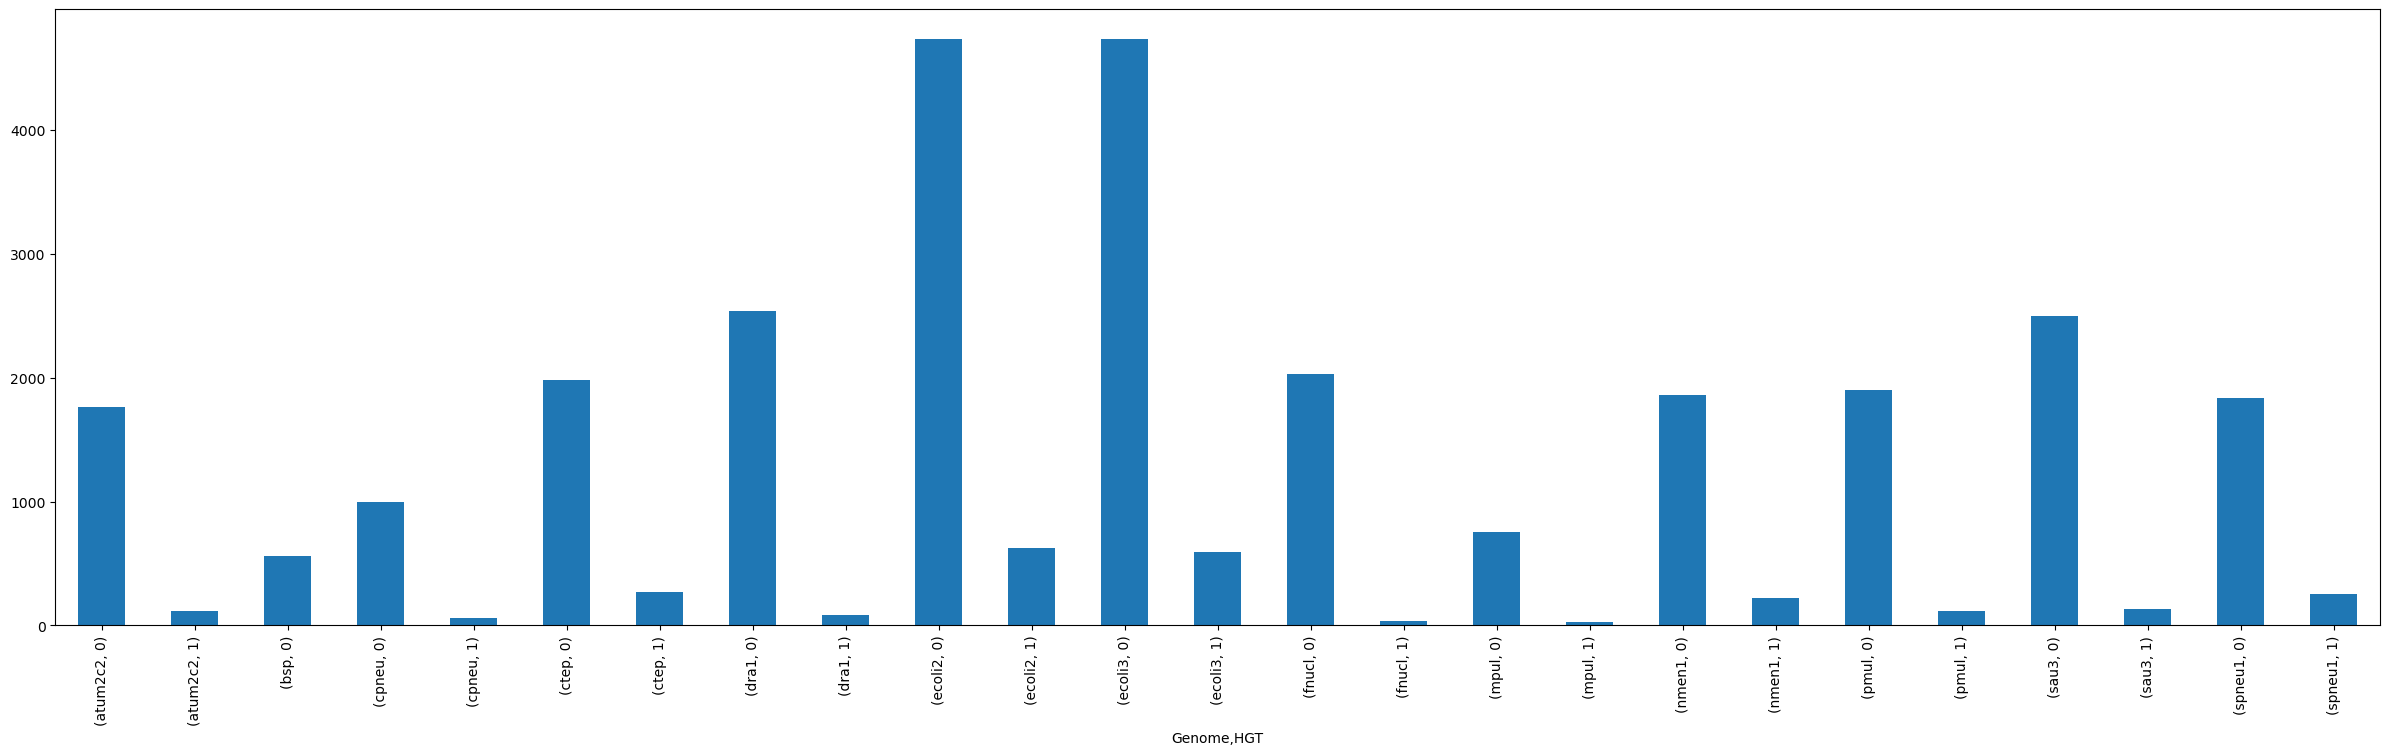

In [17]:
df_fold_2.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

### Fold 3

<Axes: xlabel='Genome,HGT'>

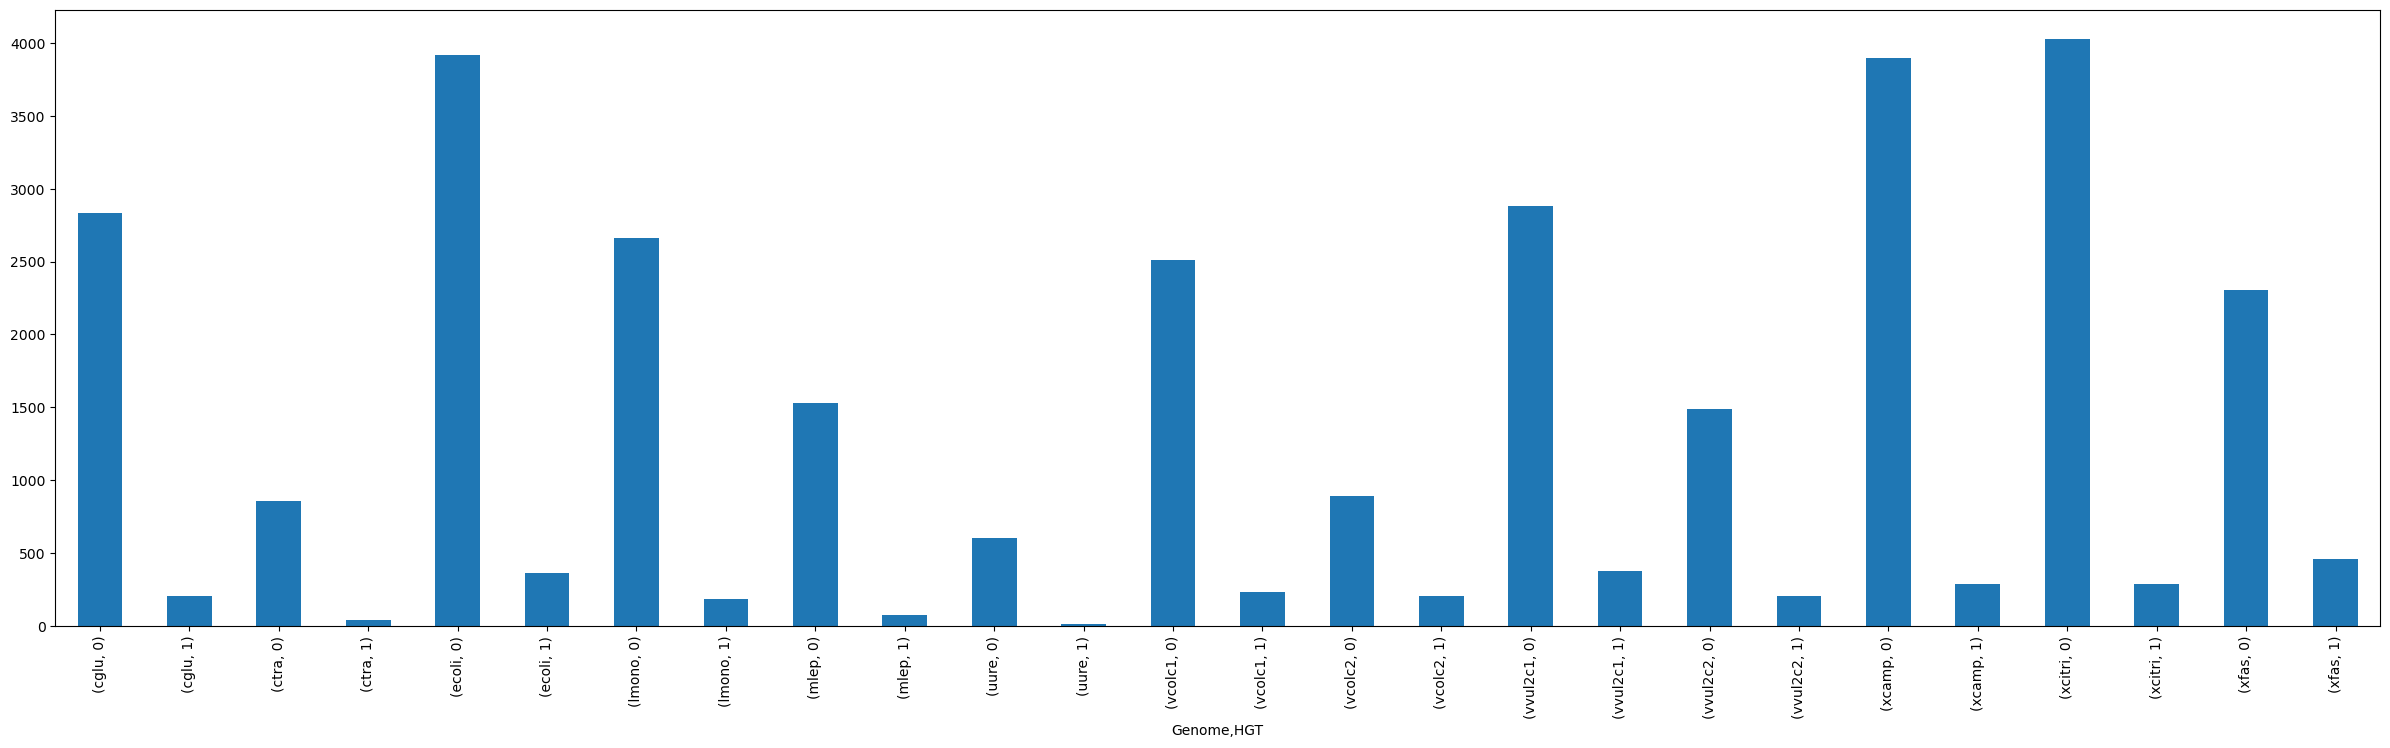

In [18]:
df_fold_3.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

### Fold 4

<Axes: xlabel='Genome,HGT'>

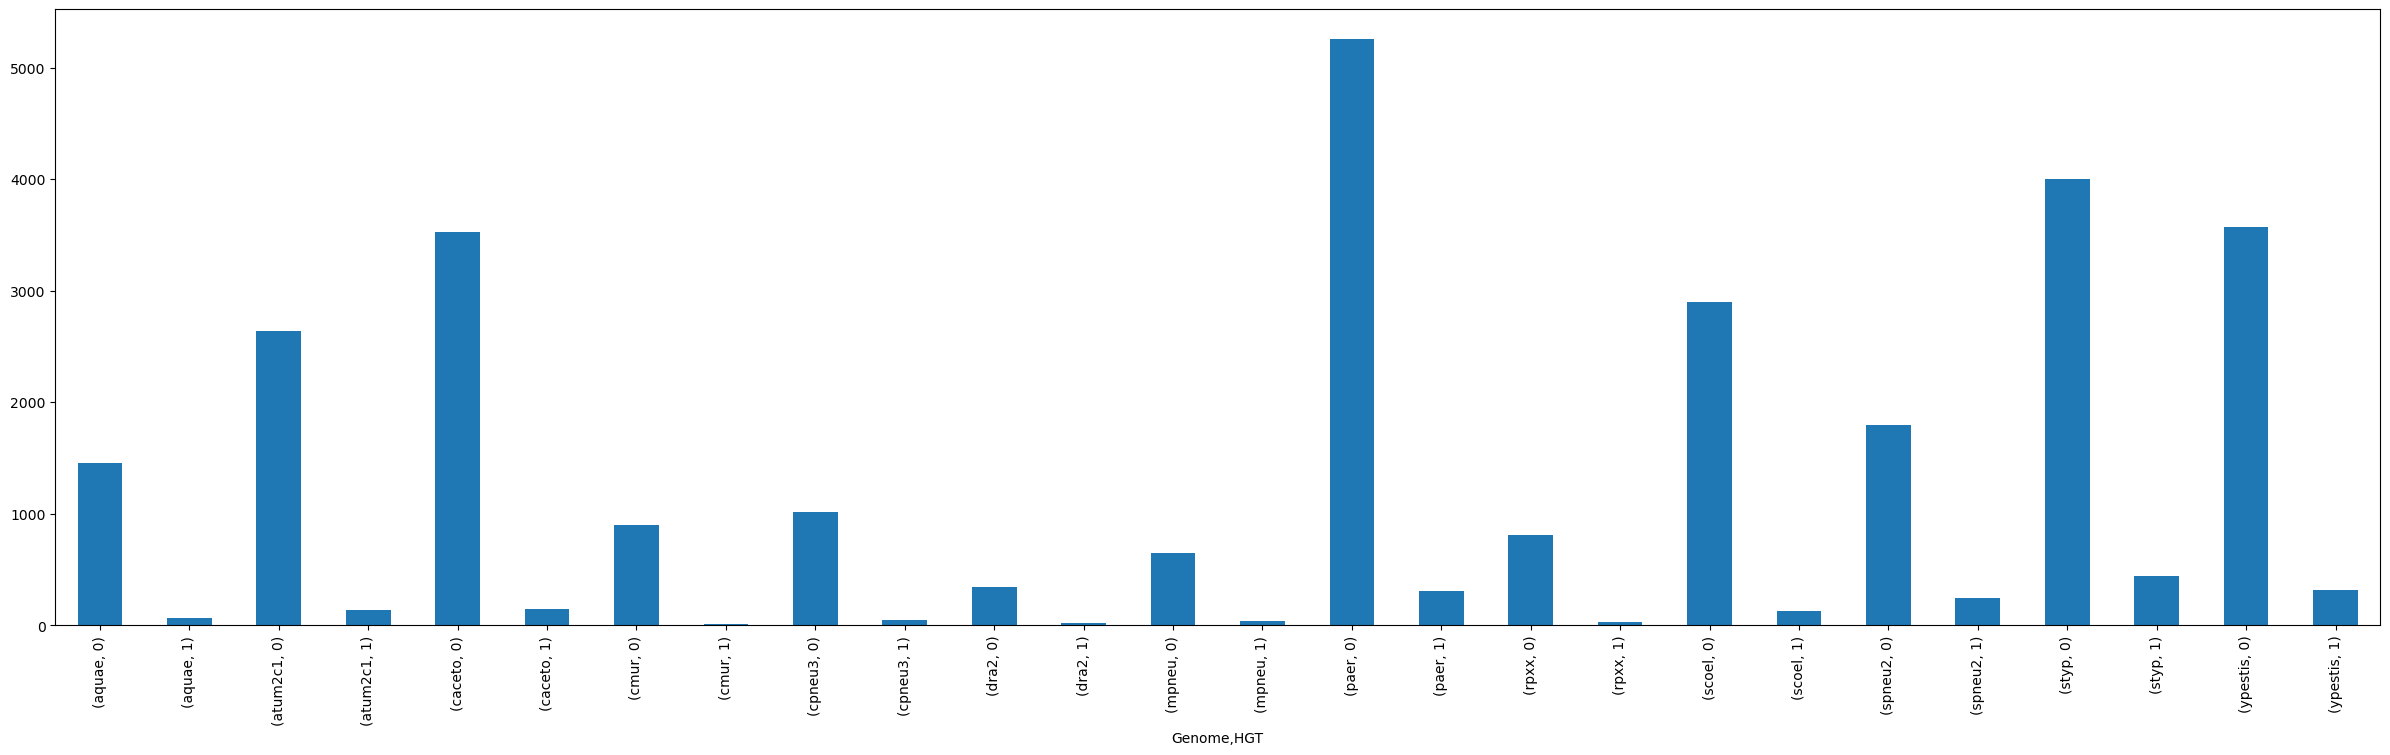

In [19]:
df_fold_4.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

### Fold 5

<Axes: xlabel='Genome,HGT'>

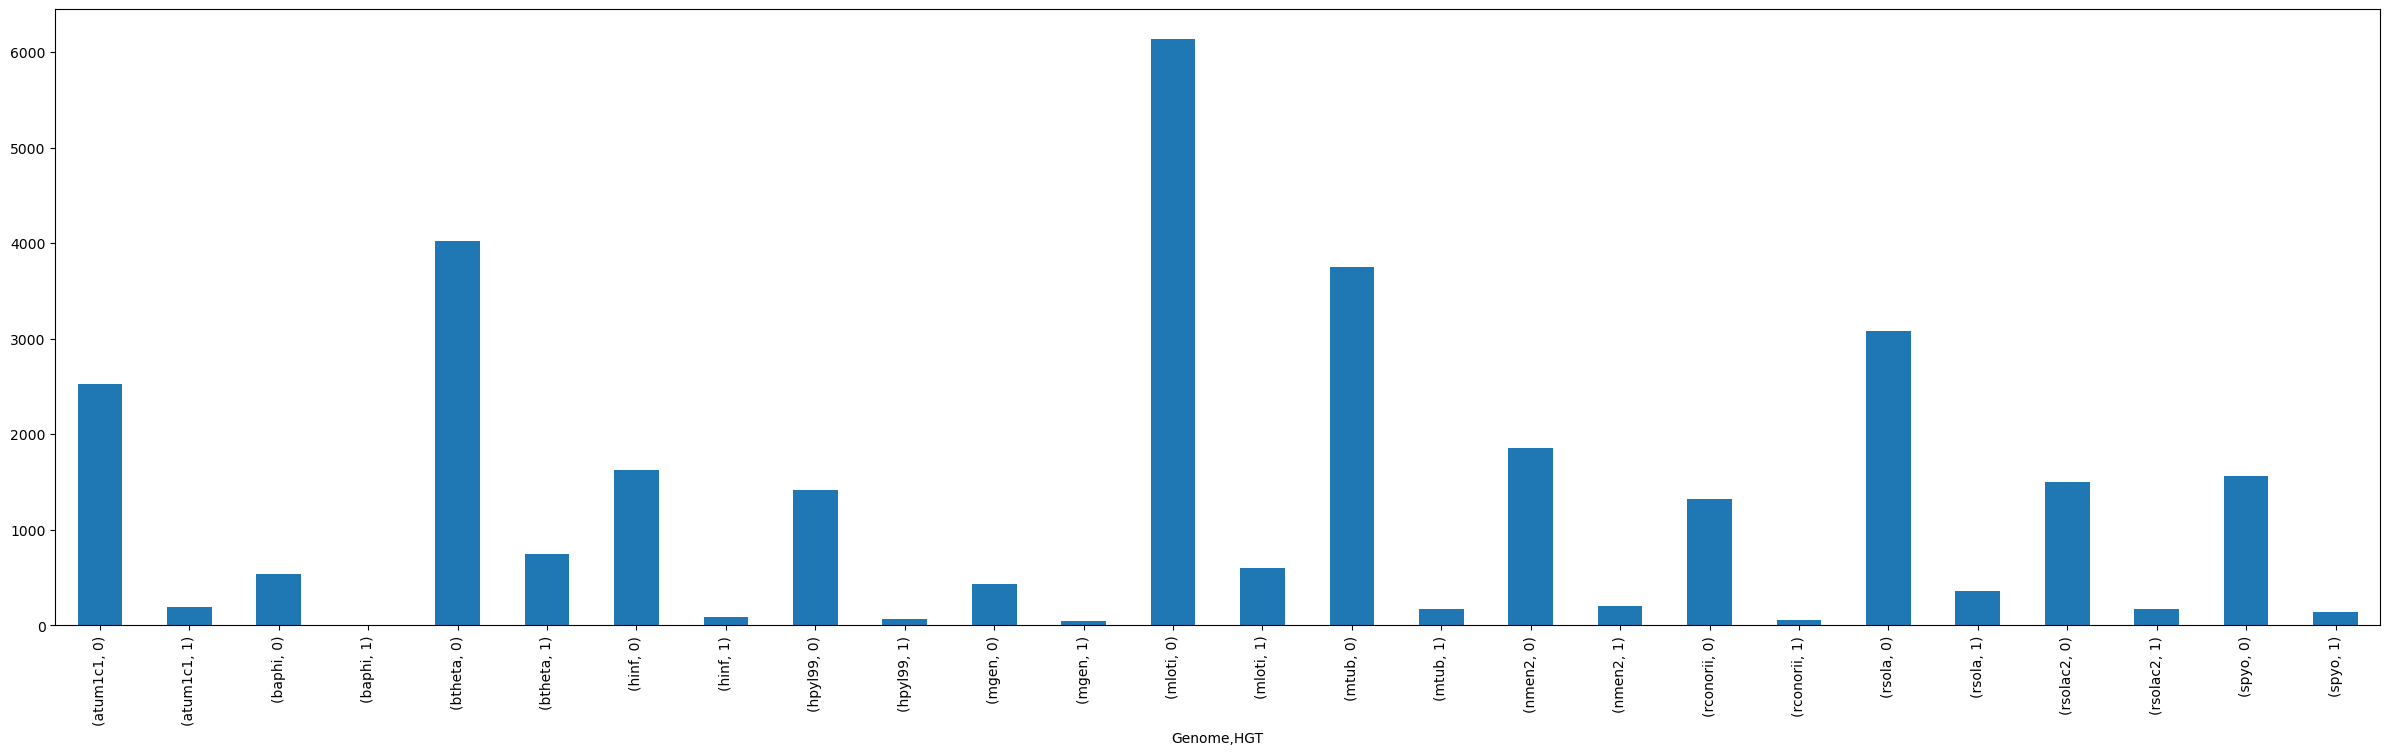

In [20]:
df_fold_5.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

### Fold 6

<Axes: xlabel='Genome,HGT'>

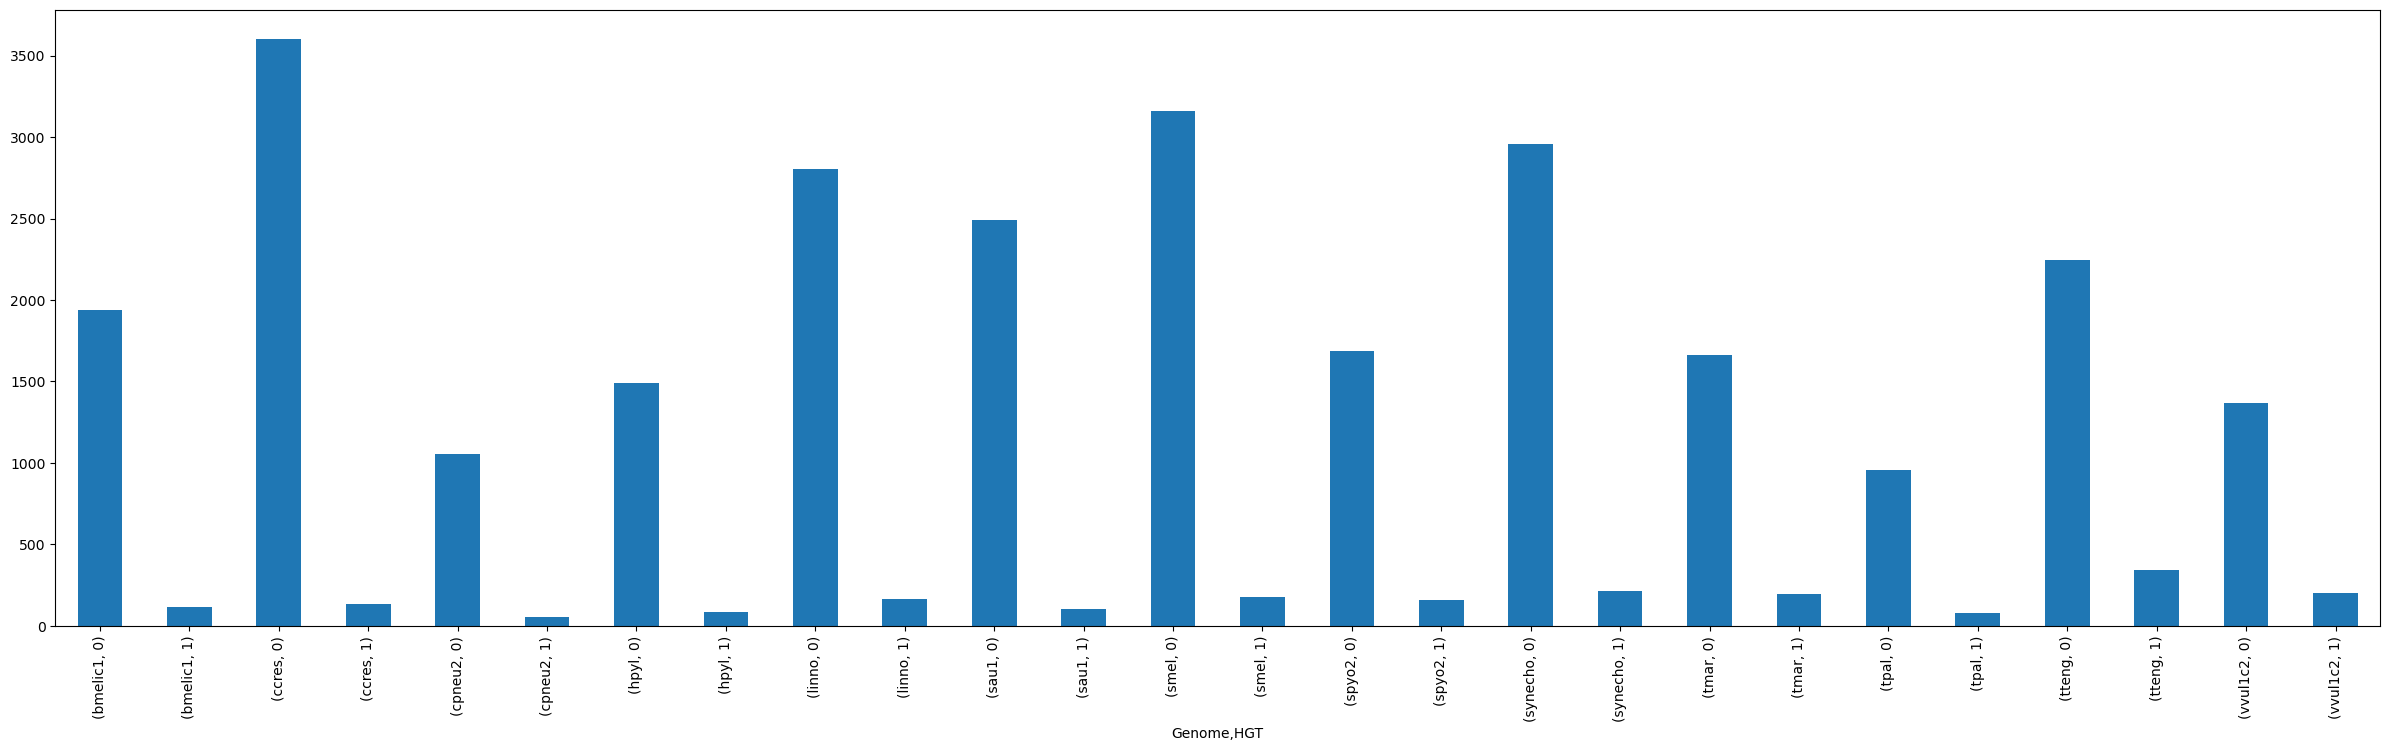

In [21]:
df_fold_6.groupby('Genome')['HGT'].value_counts().plot(kind='bar',figsize=(30,8))

# Hold-Out CV

## LightGBM

In [22]:
# init model and init classifier
HGT_B_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_B_lgbm.train(X_B_train, y_B_train)
HGT_B_lgbm.eval(X_B_test, y_B_test)
HGT_B_lgbm.get_precision(X_B_test, y_B_test)
HGT_B_lgbm.get_roc_auc(X_B_test, y_B_test)

[[56241   973]
 [ 3238  1650]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     57214
         1.0       0.63      0.34      0.44      4888

    accuracy                           0.93     62102
   macro avg       0.79      0.66      0.70     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6290507052992756
roc_auc: 0.9348805006894894


In [23]:
# init model and init classifier
HGT_C_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_C_lgbm.train(X_C_train, y_C_train)
HGT_C_lgbm.eval(X_C_test, y_C_test)
HGT_C_lgbm.get_precision(X_C_test, y_C_test)
HGT_C_lgbm.get_roc_auc(X_C_test, y_C_test)

[[56264   950]
 [ 3260  1628]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     57214
         1.0       0.63      0.33      0.44      4888

    accuracy                           0.93     62102
   macro avg       0.79      0.66      0.70     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6314972847168348
roc_auc: 0.9352176433445925


In [24]:
# init model and init classifier
HGT_D_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_D_lgbm.train(X_D_train, y_D_train)
HGT_D_lgbm.eval(X_D_test, y_D_test)
HGT_D_lgbm.get_precision(X_D_test, y_D_test)
HGT_D_lgbm.get_roc_auc(X_D_test, y_D_test)

[[56327   887]
 [ 3557  1331]]
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     57214
         1.0       0.60      0.27      0.37      4888

    accuracy                           0.93     62102
   macro avg       0.77      0.63      0.67     62102
weighted avg       0.91      0.93      0.92     62102

prec: 0.6000901713255185
roc_auc: 0.9285761000263346


In [25]:
# init model and init classifier
HGT_E_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_E_lgbm.train(X_E_train, y_E_train)
HGT_E_lgbm.eval(X_E_test, y_E_test)
HGT_E_lgbm.get_precision(X_E_test, y_E_test)
HGT_E_lgbm.get_roc_auc(X_E_test, y_E_test)

[[56268   946]
 [ 3301  1587]]
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     57214
         1.0       0.63      0.32      0.43      4888

    accuracy                           0.93     62102
   macro avg       0.79      0.65      0.70     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6265298065534939
roc_auc: 0.9326664639982306


## Weighted Class LightGBM

Taken from LightGBM Documentation

For Binary classifier us is_unblance True for class weights

In [26]:
# init model and init classifier
HGT_B_weighted_class_lgbm = MLClassifier(LGBMClassifier(is_unbalance=True))

# train and eval
HGT_B_weighted_class_lgbm.train(X_B_train, y_B_train)
HGT_B_weighted_class_lgbm.eval(X_B_test, y_B_test)
HGT_B_weighted_class_lgbm.get_precision(X_B_test, y_B_test)
HGT_B_weighted_class_lgbm.get_roc_auc(X_B_test, y_B_test)

[[48074  9140]
 [  596  4292]]
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     57214
         1.0       0.32      0.88      0.47      4888

    accuracy                           0.84     62102
   macro avg       0.65      0.86      0.69     62102
weighted avg       0.94      0.84      0.87     62102

prec: 0.31953543776057175
roc_auc: 0.9350010712215665


In [27]:
# init model and init classifier
HGT_C_weighted_class_lgbm = MLClassifier(LGBMClassifier(is_unbalance=True))

# train and eval
HGT_C_weighted_class_lgbm.train(X_C_train, y_C_train)
HGT_C_weighted_class_lgbm.eval(X_C_test, y_C_test)
HGT_C_weighted_class_lgbm.get_precision(X_C_test, y_C_test)
HGT_C_weighted_class_lgbm.get_roc_auc(X_C_test, y_C_test)

[[48063  9151]
 [  596  4292]]
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     57214
         1.0       0.32      0.88      0.47      4888

    accuracy                           0.84     62102
   macro avg       0.65      0.86      0.69     62102
weighted avg       0.94      0.84      0.87     62102

prec: 0.3192739715837239
roc_auc: 0.9351141970533918


In [28]:
# init model and init classifier
HGT_D_weighted_class_lgbm = MLClassifier(LGBMClassifier(is_unbalance=True))

# train and eval
HGT_D_weighted_class_lgbm.train(X_D_train, y_D_train)
HGT_D_weighted_class_lgbm.eval(X_D_test, y_D_test)
HGT_D_weighted_class_lgbm.get_precision(X_D_test, y_D_test)
HGT_D_weighted_class_lgbm.get_roc_auc(X_D_test, y_D_test)

[[46517 10697]
 [  508  4380]]
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     57214
         1.0       0.29      0.90      0.44      4888

    accuracy                           0.82     62102
   macro avg       0.64      0.85      0.67     62102
weighted avg       0.93      0.82      0.86     62102

prec: 0.29050872189427607
roc_auc: 0.9281535685902474


In [29]:
# init model and init classifier
HGT_E_weighted_class_lgbm = MLClassifier(LGBMClassifier(is_unbalance=True))

# train and eval
HGT_E_weighted_class_lgbm.train(X_E_train, y_E_train)
HGT_E_weighted_class_lgbm.eval(X_E_test, y_E_test)
HGT_E_weighted_class_lgbm.get_precision(X_E_test, y_E_test)
HGT_E_weighted_class_lgbm.get_roc_auc(X_E_test, y_E_test)

[[47156 10058]
 [  555  4333]]
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     57214
         1.0       0.30      0.89      0.45      4888

    accuracy                           0.83     62102
   macro avg       0.64      0.86      0.67     62102
weighted avg       0.93      0.83      0.86     62102

prec: 0.301090959627545
roc_auc: 0.9327597962958376


## Weighted Samples LightGBM

In [12]:
# init model and init classifier
HGT_B_weighted_samples_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_B_weighted_samples_lgbm.train(X_B_train, y_B_train, sample_weights_B)
HGT_B_weighted_samples_lgbm.eval(X_B_test, y_B_test)
HGT_B_weighted_samples_lgbm.get_precision(X_B_test, y_B_test)
HGT_B_weighted_samples_lgbm.get_roc_auc(X_B_test, y_B_test)

[[48288  8926]
 [  604  4284]]
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     57214
         1.0       0.32      0.88      0.47      4888

    accuracy                           0.85     62102
   macro avg       0.66      0.86      0.69     62102
weighted avg       0.94      0.85      0.88     62102

prec: 0.3242997728993187
roc_auc: 0.935533878621035


In [21]:
# init model and init classifier
HGT_C_weighted_samples_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_C_weighted_samples_lgbm.train(X_C_train, y_C_train, sample_weights_C)
HGT_C_weighted_samples_lgbm.eval(X_C_test, y_C_test)
HGT_C_weighted_samples_lgbm.get_precision(X_C_test, y_C_test)
HGT_C_weighted_samples_lgbm.get_roc_auc(X_C_test, y_C_test)

[[48258  8956]
 [  590  4298]]
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     57214
         1.0       0.32      0.88      0.47      4888

    accuracy                           0.85     62102
   macro avg       0.66      0.86      0.69     62102
weighted avg       0.94      0.85      0.88     62102

prec: 0.3242794628036819
roc_auc: 0.9353147873859402


In [24]:
# init model and init classifier
HGT_D_weighted_samples_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_D_weighted_samples_lgbm.train(X_D_train, y_D_train, sample_weights_D)
HGT_D_weighted_samples_lgbm.eval(X_D_test, y_D_test)
HGT_D_weighted_samples_lgbm.get_precision(X_D_test, y_D_test)
HGT_D_weighted_samples_lgbm.get_roc_auc(X_D_test, y_D_test)

[[46530 10684]
 [  493  4395]]
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     57214
         1.0       0.29      0.90      0.44      4888

    accuracy                           0.82     62102
   macro avg       0.64      0.86      0.67     62102
weighted avg       0.93      0.82      0.86     62102

prec: 0.2914649512567146
roc_auc: 0.9286484462789


In [23]:
# init model and init classifier
HGT_E_weighted_samples_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_E_weighted_samples_lgbm.train(X_E_train, y_E_train, sample_weights_E)
HGT_E_weighted_samples_lgbm.eval(X_E_test, y_E_test)
HGT_E_weighted_samples_lgbm.get_precision(X_E_test, y_E_test)
HGT_E_weighted_samples_lgbm.get_roc_auc(X_E_test, y_E_test)

[[47095 10119]
 [  518  4370]]
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     57214
         1.0       0.30      0.89      0.45      4888

    accuracy                           0.83     62102
   macro avg       0.65      0.86      0.67     62102
weighted avg       0.94      0.83      0.86     62102

prec: 0.30160811650217406
roc_auc: 0.9331129046505676


## Weighted Class and Weighted Samples LightGBM

In [22]:
# init model and init classifier
HGT_B_weighted_class_and_weights_lgbm = MLClassifier(LGBMClassifier(is_unbalance=True))

# train and eval
HGT_B_weighted_class_and_weights_lgbm.train(X_B_train, y_B_train, sample_weights_B)
HGT_B_weighted_class_and_weights_lgbm.eval(X_B_test, y_B_test)
HGT_B_weighted_class_and_weights_lgbm.get_precision(X_B_test, y_B_test)
HGT_B_weighted_class_and_weights_lgbm.get_roc_auc(X_B_test, y_B_test)

[[39669 17545]
 [   86  4802]]
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82     57214
         1.0       0.21      0.98      0.35      4888

    accuracy                           0.72     62102
   macro avg       0.61      0.84      0.59     62102
weighted avg       0.94      0.72      0.78     62102

prec: 0.2148834295431154
roc_auc: 0.9352978294171874


In [25]:
# init model and init classifier
HGT_C_weighted_class_and_weights_lgbm = MLClassifier(LGBMClassifier(is_unbalance=True))

# train and eval
HGT_C_weighted_class_and_weights_lgbm.train(X_C_train, y_C_train, sample_weights_C)
HGT_C_weighted_class_and_weights_lgbm.eval(X_C_test, y_C_test)
HGT_C_weighted_class_and_weights_lgbm.get_precision(X_C_test, y_C_test)
HGT_C_weighted_class_and_weights_lgbm.get_roc_auc(X_C_test, y_C_test)

[[39685 17529]
 [   92  4796]]
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82     57214
         1.0       0.21      0.98      0.35      4888

    accuracy                           0.72     62102
   macro avg       0.61      0.84      0.59     62102
weighted avg       0.94      0.72      0.78     62102

prec: 0.21482642777155656
roc_auc: 0.9354267975854512


In [26]:
# init model and init classifier
HGT_D_weighted_class_and_weights_lgbm = MLClassifier(LGBMClassifier(is_unbalance=True))

# train and eval
HGT_D_weighted_class_and_weights_lgbm.train(X_D_train, y_D_train, sample_weights_D)
HGT_D_weighted_class_and_weights_lgbm.eval(X_D_test, y_D_test)
HGT_D_weighted_class_and_weights_lgbm.get_precision(X_D_test, y_D_test)
HGT_D_weighted_class_and_weights_lgbm.get_roc_auc(X_D_test, y_D_test)

[[36703 20511]
 [   53  4835]]
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78     57214
         1.0       0.19      0.99      0.32      4888

    accuracy                           0.67     62102
   macro avg       0.59      0.82      0.55     62102
weighted avg       0.93      0.67      0.74     62102

prec: 0.1907598832162866
roc_auc: 0.9283300977374005


In [27]:
# init model and init classifier
HGT_E_weighted_class_and_weights_lgbm = MLClassifier(LGBMClassifier(is_unbalance=True))

# train and eval
HGT_E_weighted_class_and_weights_lgbm.train(X_E_train, y_E_train, sample_weights_E)
HGT_E_weighted_class_and_weights_lgbm.eval(X_E_test, y_E_test)
HGT_E_weighted_class_and_weights_lgbm.get_precision(X_E_test, y_E_test)
HGT_E_weighted_class_and_weights_lgbm.get_roc_auc(X_E_test, y_E_test)

[[38426 18788]
 [   79  4809]]
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80     57214
         1.0       0.20      0.98      0.34      4888

    accuracy                           0.70     62102
   macro avg       0.60      0.83      0.57     62102
weighted avg       0.94      0.70      0.77     62102

prec: 0.20379709285078612
roc_auc: 0.9327567086403776


## HistGradientBoostingClassifier

In [30]:
# init model and init classifier
HGT_B_hgbc = MLClassifier(HistGradientBoostingClassifier())
# train and eval
HGT_B_hgbc.train(X_B_train, y_B_train)
HGT_B_hgbc.eval(X_B_test, y_B_test)
HGT_B_hgbc.get_precision(X_B_test, y_B_test)
HGT_B_hgbc.get_roc_auc(X_B_test, y_B_test)

[[56259   955]
 [ 3258  1630]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     57214
         1.0       0.63      0.33      0.44      4888

    accuracy                           0.93     62102
   macro avg       0.79      0.66      0.70     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6305609284332688
roc_auc: 0.9345300079919322


In [31]:
# init model and init classifier
HGT_C_hgbc = MLClassifier(HistGradientBoostingClassifier())
# train and eval
HGT_C_hgbc.train(X_C_train, y_C_train)
HGT_C_hgbc.eval(X_C_test, y_C_test)
HGT_C_hgbc.get_precision(X_C_test, y_C_test)
HGT_C_hgbc.get_roc_auc(X_C_test, y_C_test)

[[56248   966]
 [ 3297  1591]]
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     57214
         1.0       0.62      0.33      0.43      4888

    accuracy                           0.93     62102
   macro avg       0.78      0.65      0.70     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6222135314822057
roc_auc: 0.9346945351523442


In [32]:
# init model and init classifier
HGT_D_hgbc = MLClassifier(HistGradientBoostingClassifier())
# train and eval
HGT_D_hgbc.train(X_D_train, y_D_train)
HGT_D_hgbc.eval(X_D_test, y_D_test)
HGT_D_hgbc.get_precision(X_D_test, y_D_test)
HGT_D_hgbc.get_roc_auc(X_D_test, y_D_test)

[[56336   878]
 [ 3605  1283]]
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     57214
         1.0       0.59      0.26      0.36      4888

    accuracy                           0.93     62102
   macro avg       0.77      0.62      0.66     62102
weighted avg       0.91      0.93      0.91     62102

prec: 0.5937066173068024
roc_auc: 0.9283846439333603


In [33]:
# init model and init classifier
HGT_E_hgbc = MLClassifier(HistGradientBoostingClassifier())
# train and eval
HGT_E_hgbc.train(X_E_train, y_E_train)
HGT_E_hgbc.eval(X_E_test, y_E_test)
HGT_E_hgbc.get_precision(X_E_test, y_E_test)
HGT_E_hgbc.get_roc_auc(X_E_test, y_E_test)

[[56246   968]
 [ 3264  1624]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     57214
         1.0       0.63      0.33      0.43      4888

    accuracy                           0.93     62102
   macro avg       0.79      0.66      0.70     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6265432098765432
roc_auc: 0.9321221784586046


## Weighted Class HistGradientBoostingClassifier

In [28]:
# class 0 is 0.01 as important as class 1
class_weight ={
    0:0.01,
    1:1
}

In [35]:
# init model and init classifier
HGT_B_weighted_class_hgbc = MLClassifier(HistGradientBoostingClassifier(class_weight=class_weight))
# train and eval
HGT_B_weighted_class_hgbc.train(X_B_train, y_B_train)
HGT_B_weighted_class_hgbc.eval(X_B_test, y_B_test)
HGT_B_weighted_class_hgbc.get_precision(X_B_test, y_B_test)
HGT_B_weighted_class_hgbc.get_roc_auc(X_B_test, y_B_test)

[[40012 17202]
 [  106  4782]]
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82     57214
         1.0       0.22      0.98      0.36      4888

    accuracy                           0.72     62102
   macro avg       0.61      0.84      0.59     62102
weighted avg       0.94      0.72      0.79     62102

prec: 0.21752183406113537
roc_auc: 0.9325290946180351


In [36]:
# init model and init classifier
HGT_C_weighted_class_hgbc = MLClassifier(HistGradientBoostingClassifier(class_weight=class_weight))
# train and eval
HGT_C_weighted_class_hgbc.train(X_C_train, y_C_train)
HGT_C_weighted_class_hgbc.eval(X_C_test, y_C_test)
HGT_C_weighted_class_hgbc.get_precision(X_C_test, y_C_test)
HGT_C_weighted_class_hgbc.get_roc_auc(X_C_test, y_C_test)

[[40426 16788]
 [  123  4765]]
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     57214
         1.0       0.22      0.97      0.36      4888

    accuracy                           0.73     62102
   macro avg       0.61      0.84      0.59     62102
weighted avg       0.94      0.73      0.79     62102

prec: 0.22108291189161602
roc_auc: 0.930384813552381


In [37]:
# init model and init classifier
HGT_D_weighted_class_hgbc = MLClassifier(HistGradientBoostingClassifier(class_weight=class_weight))
# train and eval
HGT_D_weighted_class_hgbc.train(X_D_train, y_D_train)
HGT_D_weighted_class_hgbc.eval(X_D_test, y_D_test)
HGT_D_weighted_class_hgbc.get_precision(X_D_test, y_D_test)
HGT_D_weighted_class_hgbc.get_roc_auc(X_D_test, y_D_test)

[[37840 19374]
 [   90  4798]]
              precision    recall  f1-score   support

         0.0       1.00      0.66      0.80     57214
         1.0       0.20      0.98      0.33      4888

    accuracy                           0.69     62102
   macro avg       0.60      0.82      0.56     62102
weighted avg       0.93      0.69      0.76     62102

prec: 0.19849412543438688
roc_auc: 0.9275323830873117


In [38]:
# init model and init classifier
HGT_E_weighted_class_hgbc = MLClassifier(HistGradientBoostingClassifier(class_weight=class_weight))
# train and eval
HGT_E_weighted_class_hgbc.train(X_E_train, y_E_train)
HGT_E_weighted_class_hgbc.eval(X_E_test, y_E_test)
HGT_E_weighted_class_hgbc.get_precision(X_E_test, y_E_test)
HGT_E_weighted_class_hgbc.get_roc_auc(X_E_test, y_E_test)

[[39472 17742]
 [  132  4756]]
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82     57214
         1.0       0.21      0.97      0.35      4888

    accuracy                           0.71     62102
   macro avg       0.60      0.83      0.58     62102
weighted avg       0.93      0.71      0.78     62102

prec: 0.21139656858387412
roc_auc: 0.9295955108414573


## Weighted Samples HGBC

In [29]:
# init model and init classifier
HGT_B_weighted_samples_hgbc = MLClassifier(HistGradientBoostingClassifier())
# train and eval
HGT_B_weighted_samples_hgbc.train(X_B_train, y_B_train, sample_weights_B)
HGT_B_weighted_samples_hgbc.eval(X_B_test, y_B_test)
HGT_B_weighted_samples_hgbc.get_precision(X_B_test, y_B_test)
HGT_B_weighted_samples_hgbc.get_roc_auc(X_B_test, y_B_test)

[[48395  8819]
 [  605  4283]]
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91     57214
         1.0       0.33      0.88      0.48      4888

    accuracy                           0.85     62102
   macro avg       0.66      0.86      0.69     62102
weighted avg       0.94      0.85      0.88     62102

prec: 0.32689665699893145
roc_auc: 0.9352889365403738


In [31]:
# init model and init classifier
HGT_C_weighted_samples_hgbc = MLClassifier(HistGradientBoostingClassifier())
# train and eval
HGT_C_weighted_samples_hgbc.train(X_C_train, y_C_train, sample_weights_C)
HGT_C_weighted_samples_hgbc.eval(X_C_test, y_C_test)
HGT_C_weighted_samples_hgbc.get_precision(X_C_test, y_C_test)
HGT_C_weighted_samples_hgbc.get_roc_auc(X_C_test, y_C_test)

[[48338  8876]
 [  610  4278]]
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     57214
         1.0       0.33      0.88      0.47      4888

    accuracy                           0.85     62102
   macro avg       0.66      0.86      0.69     62102
weighted avg       0.94      0.85      0.88     62102

prec: 0.32522426638284935
roc_auc: 0.9345441375467085


In [32]:
# init model and init classifier
HGT_D_weighted_samples_hgbc = MLClassifier(HistGradientBoostingClassifier())
# train and eval
HGT_D_weighted_samples_hgbc.train(X_D_train, y_D_train, sample_weights_D)
HGT_D_weighted_samples_hgbc.eval(X_D_test, y_D_test)
HGT_D_weighted_samples_hgbc.get_precision(X_D_test, y_D_test)
HGT_D_weighted_samples_hgbc.get_roc_auc(X_D_test, y_D_test)

[[46601 10613]
 [  500  4388]]
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     57214
         1.0       0.29      0.90      0.44      4888

    accuracy                           0.82     62102
   macro avg       0.64      0.86      0.67     62102
weighted avg       0.93      0.82      0.86     62102

prec: 0.29251383241117257
roc_auc: 0.9284250534230546


In [33]:
# init model and init classifier
HGT_E_weighted_samples_hgbc = MLClassifier(HistGradientBoostingClassifier())
# train and eval
HGT_E_weighted_samples_hgbc.train(X_E_train, y_E_train, sample_weights_E)
HGT_E_weighted_samples_hgbc.eval(X_E_test, y_E_test)
HGT_E_weighted_samples_hgbc.get_precision(X_E_test, y_E_test)
HGT_E_weighted_samples_hgbc.get_roc_auc(X_E_test, y_E_test)

[[47215  9999]
 [  533  4355]]
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90     57214
         1.0       0.30      0.89      0.45      4888

    accuracy                           0.83     62102
   macro avg       0.65      0.86      0.68     62102
weighted avg       0.93      0.83      0.86     62102

prec: 0.3033997491988296
roc_auc: 0.9331518963575293


## Weighted Class and Weighted Samples HGBC

In [30]:
# init model and init classifier
HGT_B_weighted_class_and_samples_hgbc = MLClassifier(HistGradientBoostingClassifier(class_weight=class_weight))
# train and eval
HGT_B_weighted_class_and_samples_hgbc.train(X_B_train, y_B_train, sample_weights_B)
HGT_B_weighted_class_and_samples_hgbc.eval(X_B_test, y_B_test)
HGT_B_weighted_class_and_samples_hgbc.get_precision(X_B_test, y_B_test)
HGT_B_weighted_class_and_samples_hgbc.get_roc_auc(X_B_test, y_B_test)

[[18728 38486]
 [    3  4885]]
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.49     57214
         1.0       0.11      1.00      0.20      4888

    accuracy                           0.38     62102
   macro avg       0.56      0.66      0.35     62102
weighted avg       0.93      0.38      0.47     62102

prec: 0.11263286527864241
roc_auc: 0.9174019750382132


In [34]:
# init model and init classifier
HGT_C_weighted_class_and_samples_hgbc = MLClassifier(HistGradientBoostingClassifier(class_weight=class_weight))
# train and eval
HGT_C_weighted_class_and_samples_hgbc.train(X_C_train, y_C_train, sample_weights_C)
HGT_C_weighted_class_and_samples_hgbc.eval(X_C_test, y_C_test)
HGT_C_weighted_class_and_samples_hgbc.get_precision(X_C_test, y_C_test)
HGT_C_weighted_class_and_samples_hgbc.get_roc_auc(X_C_test, y_C_test)

[[19255 37959]
 [    2  4886]]
              precision    recall  f1-score   support

         0.0       1.00      0.34      0.50     57214
         1.0       0.11      1.00      0.20      4888

    accuracy                           0.39     62102
   macro avg       0.56      0.67      0.35     62102
weighted avg       0.93      0.39      0.48     62102

prec: 0.11403897771035126
roc_auc: 0.9173683594632538


In [35]:
# init model and init classifier
HGT_D_weighted_class_and_samples_hgbc = MLClassifier(HistGradientBoostingClassifier(class_weight=class_weight))
# train and eval
HGT_D_weighted_class_and_samples_hgbc.train(X_D_train, y_D_train, sample_weights_D)
HGT_D_weighted_class_and_samples_hgbc.eval(X_D_test, y_D_test)
HGT_D_weighted_class_and_samples_hgbc.get_precision(X_D_test, y_D_test)
HGT_D_weighted_class_and_samples_hgbc.get_roc_auc(X_D_test, y_D_test)

[[18811 38403]
 [    0  4888]]
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.49     57214
         1.0       0.11      1.00      0.20      4888

    accuracy                           0.38     62102
   macro avg       0.56      0.66      0.35     62102
weighted avg       0.93      0.38      0.47     62102

prec: 0.11291030468226652
roc_auc: 0.9150942484748876


In [36]:
# init model and init classifier
HGT_E_weighted_class_and_samples_hgbc = MLClassifier(HistGradientBoostingClassifier(class_weight=class_weight))
# train and eval
HGT_E_weighted_class_and_samples_hgbc.train(X_E_train, y_E_train, sample_weights_E)
HGT_E_weighted_class_and_samples_hgbc.eval(X_E_test, y_E_test)
HGT_E_weighted_class_and_samples_hgbc.get_precision(X_E_test, y_E_test)
HGT_E_weighted_class_and_samples_hgbc.get_roc_auc(X_E_test, y_E_test)

[[17743 39471]
 [    1  4887]]
              precision    recall  f1-score   support

         0.0       1.00      0.31      0.47     57214
         1.0       0.11      1.00      0.20      4888

    accuracy                           0.36     62102
   macro avg       0.56      0.65      0.34     62102
weighted avg       0.93      0.36      0.45     62102

prec: 0.11017178412011362
roc_auc: 0.9158976306801633


## XGBoost

In [39]:
# init model and init classifier
HGT_B_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_B_xgbc.train(X_B_train, y_B_train)
HGT_B_xgbc.eval(X_B_test, y_B_test)
HGT_B_xgbc.get_precision(X_B_test, y_B_test)
HGT_B_xgbc.get_roc_auc(X_B_test, y_B_test)

[[56110  1104]
 [ 3146  1742]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     57214
         1.0       0.61      0.36      0.45      4888

    accuracy                           0.93     62102
   macro avg       0.78      0.67      0.71     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6120871398453971
roc_auc: 0.9333895725251684


In [40]:
# init model and init classifier
HGT_C_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_C_xgbc.train(X_C_train, y_C_train)
HGT_C_xgbc.eval(X_C_test, y_C_test)
HGT_C_xgbc.get_precision(X_C_test, y_C_test)
HGT_C_xgbc.get_roc_auc(X_C_test, y_C_test)

[[56135  1079]
 [ 3175  1713]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     57214
         1.0       0.61      0.35      0.45      4888

    accuracy                           0.93     62102
   macro avg       0.78      0.67      0.70     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6135386819484241
roc_auc: 0.9331285467453087


In [41]:
# init model and init classifier
HGT_D_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_D_xgbc.train(X_D_train, y_D_train)
HGT_D_xgbc.eval(X_D_test, y_D_test)
HGT_D_xgbc.get_precision(X_D_test, y_D_test)
HGT_D_xgbc.get_roc_auc(X_D_test, y_D_test)

[[56260   954]
 [ 3510  1378]]
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     57214
         1.0       0.59      0.28      0.38      4888

    accuracy                           0.93     62102
   macro avg       0.77      0.63      0.67     62102
weighted avg       0.91      0.93      0.92     62102

prec: 0.5909090909090909
roc_auc: 0.9268146721468432


In [42]:
# init model and init classifier
HGT_E_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_E_xgbc.train(X_E_train, y_E_train)
HGT_E_xgbc.eval(X_E_test, y_E_test)
HGT_E_xgbc.get_precision(X_E_test, y_E_test)
HGT_E_xgbc.get_roc_auc(X_E_test, y_E_test)

[[56197  1017]
 [ 3252  1636]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     57214
         1.0       0.62      0.33      0.43      4888

    accuracy                           0.93     62102
   macro avg       0.78      0.66      0.70     62102
weighted avg       0.92      0.93      0.92     62102

prec: 0.6166603844704108
roc_auc: 0.9300991741345855


## Weighted Class XGBoost

Taken from 
https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

'For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the scale_pos_weight can be set to 100.'



In [30]:
# count examples in each class
counter_B = Counter(y_B_train)
counter_C = Counter(y_C_train)
counter_D = Counter(y_D_train)
counter_E = Counter(y_E_train)
# estimate scale_pos_weight value
estimate_B = counter_B[0] / counter_B[1]
print('Estimate: %.3f' % estimate_B)
estimate_C = counter_C[0] / counter_C[1]
print('Estimate: %.3f' % estimate_C)
estimate_D = counter_D[0] / counter_D[1]
print('Estimate: %.3f' % estimate_D)
estimate_E = counter_E[0] / counter_E[1]
print('Estimate: %.3f' % estimate_E)

Estimate: 12.198
Estimate: 12.199
Estimate: 12.199
Estimate: 12.198


In [26]:
# init model and init classifier
HGT_B_weight_class_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_B))
# train and eval
HGT_B_weight_class_xgbc.train(X_B_train, y_B_train)
HGT_B_weight_class_xgbc.eval(X_B_test, y_B_test)
HGT_B_weight_class_xgbc.get_precision(X_B_test, y_B_test)
HGT_B_weight_class_xgbc.get_roc_auc(X_B_test, y_B_test)

[[49908  7306]
 [  863  4025]]
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     57214
         1.0       0.36      0.82      0.50      4888

    accuracy                           0.87     62102
   macro avg       0.67      0.85      0.71     62102
weighted avg       0.93      0.87      0.89     62102

prec: 0.3552201923925514
roc_auc: 0.9309932962226348


In [45]:
# init model and init classifier
HGT_C_weight_class_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_C))
# train and eval
HGT_C_weight_class_xgbc.train(X_C_train, y_C_train)
HGT_C_weight_class_xgbc.eval(X_C_test, y_C_test)
HGT_C_weight_class_xgbc.get_precision(X_C_test, y_C_test)
HGT_C_weight_class_xgbc.get_roc_auc(X_C_test, y_C_test)

[[50048  7166]
 [  909  3979]]
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.93     57214
         1.0       0.36      0.81      0.50      4888

    accuracy                           0.87     62102
   macro avg       0.67      0.84      0.71     62102
weighted avg       0.93      0.87      0.89     62102

prec: 0.3570210856886496
roc_auc: 0.9298753968861959


In [46]:
# init model and init classifier
HGT_D_weight_class_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_D))
# train and eval
HGT_D_weight_class_xgbc.train(X_D_train, y_D_train)
HGT_D_weight_class_xgbc.eval(X_D_test, y_D_test)
HGT_D_weight_class_xgbc.get_precision(X_D_test, y_D_test)
HGT_D_weight_class_xgbc.get_roc_auc(X_D_test, y_D_test)

[[47540  9674]
 [  679  4209]]
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90     57214
         1.0       0.30      0.86      0.45      4888

    accuracy                           0.83     62102
   macro avg       0.64      0.85      0.68     62102
weighted avg       0.93      0.83      0.87     62102

prec: 0.30317654685586687
roc_auc: 0.9239537707428229


In [27]:
# init model and init classifier
HGT_E_weight_class_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_E))
# train and eval
HGT_E_weight_class_xgbc.train(X_E_train, y_E_train)
HGT_E_weight_class_xgbc.eval(X_E_test, y_E_test)
HGT_E_weight_class_xgbc.get_precision(X_E_test, y_E_test)
HGT_E_weight_class_xgbc.get_roc_auc(X_E_test, y_E_test)

[[48726  8488]
 [  839  4049]]
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     57214
         1.0       0.32      0.83      0.46      4888

    accuracy                           0.85     62102
   macro avg       0.65      0.84      0.69     62102
weighted avg       0.93      0.85      0.88     62102

prec: 0.32296402648161443
roc_auc: 0.9257226361710766


## Weighted Samples XGBoost

In [13]:
# init model and init classifier
HGT_B_weight_samples_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_B_weight_samples_xgbc.train(X_B_train, y_B_train, sample_weights_B)
HGT_B_weight_samples_xgbc.eval(X_B_test, y_B_test)
HGT_B_weight_samples_xgbc.get_precision(X_B_test, y_B_test)
HGT_B_weight_samples_xgbc.get_roc_auc(X_B_test, y_B_test)

[[57214     0]
 [ 4888     0]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     57214
         1.0       0.00      0.00      0.00      4888

    accuracy                           0.92     62102
   macro avg       0.46      0.50      0.48     62102
weighted avg       0.85      0.92      0.88     62102



/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

prec: 0.0
roc_auc: 0.5


In [14]:
# init model and init classifier
HGT_C_weight_samples_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_C_weight_samples_xgbc.train(X_C_train, y_C_train, sample_weights_C)
HGT_C_weight_samples_xgbc.eval(X_C_test, y_C_test)
HGT_C_weight_samples_xgbc.get_precision(X_C_test, y_C_test)
HGT_C_weight_samples_xgbc.get_roc_auc(X_C_test, y_C_test)

[[57214     0]
 [ 4888     0]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     57214
         1.0       0.00      0.00      0.00      4888

    accuracy                           0.92     62102
   macro avg       0.46      0.50      0.48     62102
weighted avg       0.85      0.92      0.88     62102

prec: 0.0
roc_auc: 0.5


/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [15]:
# init model and init classifier
HGT_D_weight_samples_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_D_weight_samples_xgbc.train(X_D_train, y_D_train, sample_weights_D)
HGT_D_weight_samples_xgbc.eval(X_D_test, y_D_test)
HGT_D_weight_samples_xgbc.get_precision(X_D_test, y_D_test)
HGT_D_weight_samples_xgbc.get_roc_auc(X_D_test, y_D_test)

[[57214     0]
 [ 4888     0]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     57214
         1.0       0.00      0.00      0.00      4888

    accuracy                           0.92     62102
   macro avg       0.46      0.50      0.48     62102
weighted avg       0.85      0.92      0.88     62102

prec: 0.0
roc_auc: 0.5


/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [43]:
# init model and init classifier
HGT_E_weight_samples_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_E_weight_samples_xgbc.train(X_E_train, y_E_train, sample_weights_E)
HGT_E_weight_samples_xgbc.eval(X_E_test, y_E_test)
HGT_E_weight_samples_xgbc.get_precision(X_E_test, y_E_test)
HGT_E_weight_samples_xgbc.get_roc_auc(X_E_test, y_E_test)

[[57214     0]
 [ 4888     0]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     57214
         1.0       0.00      0.00      0.00      4888

    accuracy                           0.92     62102
   macro avg       0.46      0.50      0.48     62102
weighted avg       0.85      0.92      0.88     62102

prec: 0.0
roc_auc: 0.5


/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

## Weighted Class and Samples XGBoost

In [44]:
# init model and init classifier
HGT_B_weight_class_and_samples_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_B))
# train and eval
HGT_B_weight_class_and_samples_xgbc.train(X_B_train, y_B_train, sample_weights_B)
HGT_B_weight_class_and_samples_xgbc.eval(X_B_test, y_B_test)
HGT_B_weight_class_and_samples_xgbc.get_precision(X_B_test, y_B_test)
HGT_B_weight_class_and_samples_xgbc.get_roc_auc(X_B_test, y_B_test)

[[    0 57214]
 [    0  4888]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     57214
         1.0       0.08      1.00      0.15      4888

    accuracy                           0.08     62102
   macro avg       0.04      0.50      0.07     62102
weighted avg       0.01      0.08      0.01     62102

prec: 0.0787092203149657
roc_auc: 0.5


/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [45]:
# init model and init classifier
HGT_C_weight_class_and_samples_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_C))
# train and eval
HGT_C_weight_class_and_samples_xgbc.train(X_C_train, y_C_train, sample_weights_C)
HGT_C_weight_class_and_samples_xgbc.eval(X_C_test, y_C_test)
HGT_C_weight_class_and_samples_xgbc.get_precision(X_C_test, y_C_test)
HGT_C_weight_class_and_samples_xgbc.get_roc_auc(X_C_test, y_C_test)

[[    0 57214]
 [    0  4888]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     57214
         1.0       0.08      1.00      0.15      4888

    accuracy                           0.08     62102
   macro avg       0.04      0.50      0.07     62102
weighted avg       0.01      0.08      0.01     62102

prec: 0.0787092203149657
roc_auc: 0.5


/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [46]:
# init model and init classifier
HGT_D_weight_class_and_samples_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_D))
# train and eval
HGT_D_weight_class_and_samples_xgbc.train(X_D_train, y_D_train, sample_weights_D)
HGT_D_weight_class_and_samples_xgbc.eval(X_D_test, y_D_test)
HGT_D_weight_class_and_samples_xgbc.get_precision(X_D_test, y_D_test)
HGT_D_weight_class_and_samples_xgbc.get_roc_auc(X_D_test, y_D_test)

[[    0 57214]
 [    0  4888]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     57214
         1.0       0.08      1.00      0.15      4888

    accuracy                           0.08     62102
   macro avg       0.04      0.50      0.07     62102
weighted avg       0.01      0.08      0.01     62102

prec: 0.0787092203149657
roc_auc: 0.5


/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [47]:
# init model and init classifier
HGT_E_weight_class_and_samples_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_E))
# train and eval
HGT_E_weight_class_and_samples_xgbc.train(X_E_train, y_E_train, sample_weights_E)
HGT_E_weight_class_and_samples_xgbc.eval(X_E_test, y_E_test)
HGT_E_weight_class_and_samples_xgbc.get_precision(X_E_test, y_E_test)
HGT_E_weight_class_and_samples_xgbc.get_roc_auc(X_E_test, y_E_test)

[[    0 57214]
 [    0  4888]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     57214
         1.0       0.08      1.00      0.15      4888

    accuracy                           0.08     62102
   macro avg       0.04      0.50      0.07     62102
weighted avg       0.01      0.08      0.01     62102

prec: 0.0787092203149657
roc_auc: 0.5


/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

# 6-fold CV

## LightGBM

### B

In [47]:
ml_cross_validator(LGBMClassifier(),ml_load_species_folds(data_type='B', drop_na=True))

prec: 0.7265625
roc_auc: 0.9496919460209721
acc: 0.9467469564079068
prec: 0.7225201072386059
roc_auc: 0.9545255640339909
acc: 0.9390132777922416
prec: 0.7148309705561614
roc_auc: 0.9538594608628433
acc: 0.9360840210052513
prec: 0.6347305389221557
roc_auc: 0.9542890575575549
acc: 0.9482680332122471
prec: 0.7152734129478315
roc_auc: 0.9489627222807684
acc: 0.9333047525722685
prec: 0.5752561071710008
roc_auc: 0.9364223959198614
acc: 0.9377164979963323
Average precision : 0.6815289394726257
Average roc_auc : 0.9496251911126653
Average accuracy : 0.9401889231643746


### C

In [48]:
ml_cross_validator(LGBMClassifier(),ml_load_species_folds(data_type='C', drop_na=True))

prec: 0.7348429510591673
roc_auc: 0.949741162468577
acc: 0.9468778635947114
prec: 0.7181571815718157
roc_auc: 0.9535049091342631
acc: 0.9383624056235356
prec: 0.7217920353982301
roc_auc: 0.9539869303451105
acc: 0.9365117465270485
prec: 0.6453794139744553
roc_auc: 0.9532854889337057
acc: 0.9491437467566165
prec: 0.7215909090909091
roc_auc: 0.9496926393699952
acc: 0.9338253307202352
prec: 0.5826580226904376
roc_auc: 0.9364873636993545
acc: 0.9381579841065001
Average precision : 0.6874034189641692
Average roc_auc : 0.9494497489918343
Average accuracy : 0.9404798462214411


### D

In [49]:
ml_cross_validator(LGBMClassifier(),ml_load_species_folds(data_type='D', drop_na=True))

prec: 0.5992537313432836
roc_auc: 0.9330964106328344
acc: 0.9370074617096479
prec: 0.5990566037735849
roc_auc: 0.9391002277968005
acc: 0.9269721426711793
prec: 0.6901709401709402
roc_auc: 0.9438606782758187
acc: 0.9284707011911548
prec: 0.5676895306859205
roc_auc: 0.9405409591984062
acc: 0.941456927867151
prec: 0.6732533521524348
roc_auc: 0.9356071915427066
acc: 0.9273640372366487
prec: 0.5224489795918368
roc_auc: 0.9278482518354636
acc: 0.9327243089044353
Average precision : 0.6086455229530001
Average roc_auc : 0.9366756198803383
Average accuracy : 0.9323325965967028


### E

In [50]:
ml_cross_validator(LGBMClassifier(),ml_load_species_folds(data_type='E', drop_na=True))

prec: 0.657314629258517
roc_auc: 0.9416890081841216
acc: 0.9423746563686346
prec: 0.6918844566712518
roc_auc: 0.9502223527672042
acc: 0.9355636552980995
prec: 0.710541989279333
roc_auc: 0.9508886950271835
acc: 0.9336534133533383
prec: 0.620532319391635
roc_auc: 0.950486838656983
acc: 0.9468733783082511
prec: 0.7048543689320388
roc_auc: 0.9441470339075797
acc: 0.9317123958843704
prec: 0.5924295774647887
roc_auc: 0.9342951446152156
acc: 0.9383617469265775
Average precision : 0.6629262234995941
Average roc_auc : 0.9452881788597146
Average accuracy : 0.9380898743565451


## Weighted Class LightGBM

In [51]:
ml_cross_validator(LGBMClassifier(is_unbalance=True),ml_load_species_folds(data_type='B', drop_na=True))

prec: 0.30056619684375374
roc_auc: 0.9512628952044396
acc: 0.8433564602696688
prec: 0.347045191193511
roc_auc: 0.9529508616947198
acc: 0.8486722207758396
prec: 0.34467821782178215
roc_auc: 0.9525794705698538
acc: 0.837119279819955
prec: 0.2957609225272048
roc_auc: 0.9538462853338532
acc: 0.855020757654385
prec: 0.35990764633980715
roc_auc: 0.9510770491733512
acc: 0.8491548260656541
prec: 0.27482851178049506
roc_auc: 0.9382993209223713
acc: 0.8286694287848944
Average precision : 0.32046444775109234
Average roc_auc : 0.9500026471497648
Average accuracy : 0.8436654955617328


In [52]:
ml_cross_validator(LGBMClassifier(is_unbalance=True),ml_load_species_folds(data_type='C', drop_na=True))

prec: 0.3015124016938899
roc_auc: 0.9513972698551887
acc: 0.8441419033904961
prec: 0.3464089991346986
roc_auc: 0.9525444041627915
acc: 0.8480864358240041
prec: 0.34313846153846156
roc_auc: 0.9527300069468658
acc: 0.8359686759278706
prec: 0.29741168810027674
roc_auc: 0.954276241935214
acc: 0.8558640373637779
prec: 0.36002171257972587
roc_auc: 0.9512314970971143
acc: 0.8491548260656541
prec: 0.27303653305724007
roc_auc: 0.9379426959872604
acc: 0.8270053657542621
Average precision : 0.3202549660173821
Average roc_auc : 0.9500203526640725
Average accuracy : 0.8433702073876774


In [53]:
ml_cross_validator(LGBMClassifier(is_unbalance=True),ml_load_species_folds(data_type='D', drop_na=True))

prec: 0.2609565950273915
roc_auc: 0.9340238796539174
acc: 0.8112318366278308
prec: 0.31340341655716164
roc_auc: 0.9382964187346305
acc: 0.8249804738349388
prec: 0.3324426090125106
roc_auc: 0.9441253918866926
acc: 0.8296678568213868
prec: 0.2664024658740643
roc_auc: 0.9414518869033285
acc: 0.8333549558899844
prec: 0.3162036485036366
roc_auc: 0.937017938621054
acc: 0.8179201371876531
prec: 0.2596222127538702
roc_auc: 0.9271408729274355
acc: 0.8162738572301841
Average precision : 0.29150515795477244
Average roc_auc : 0.9370093981211763
Average accuracy : 0.8222381862653297


In [54]:
ml_cross_validator(LGBMClassifier(is_unbalance=True),ml_load_species_folds(data_type='E', drop_na=True))

prec: 0.27356221298928496
roc_auc: 0.9419588373712839
acc: 0.8215996858227517
prec: 0.327795179082119
roc_auc: 0.9478346095712673
acc: 0.8351015360583182
prec: 0.34632362214655066
roc_auc: 0.9508216922201886
acc: 0.8393098274568642
prec: 0.2847146633494013
roc_auc: 0.9513129104685745
acc: 0.8467825635703166
prec: 0.33291598848128207
roc_auc: 0.9449150881682047
acc: 0.8305977462028418
prec: 0.2679509632224168
roc_auc: 0.9351480189329526
acc: 0.8232357535828296
Average precision : 0.3055437715451758
Average roc_auc : 0.945331859455412
Average accuracy : 0.832771185448987


## HistGradientBoosting

### Data type B

In [55]:
ml_cross_validator(HistGradientBoostingClassifier(),ml_load_species_folds(data_type='B', drop_na=True))

prec: 0.729254571026723
roc_auc: 0.9503385078083003
acc: 0.9471134965309596
prec: 0.7038007863695938
roc_auc: 0.9539927546137308
acc: 0.9376464462379589
prec: 0.7082884822389667
roc_auc: 0.9536678914411617
acc: 0.9356639159789948
prec: 0.6219512195121951
roc_auc: 0.9528543101098964
acc: 0.9476193565127141
prec: 0.7142857142857143
roc_auc: 0.9493488010572518
acc: 0.9335497305242528
prec: 0.5813397129186603
roc_auc: 0.9363945628766994
acc: 0.9381579841065001
Average precision : 0.6764867477253089
Average roc_auc : 0.9494328046511734
Average accuracy : 0.9399584883152299


### C

In [56]:
ml_cross_validator(HistGradientBoostingClassifier(),ml_load_species_folds(data_type='C', drop_na=True))

prec: 0.737410071942446
roc_auc: 0.9496110652186043
acc: 0.9473229480298468
prec: 0.7102803738317757
roc_auc: 0.9544240562254721
acc: 0.9379067951054413
prec: 0.7121791370835608
roc_auc: 0.9530419487880104
acc: 0.9357616490143719
prec: 0.6358253145817913
roc_auc: 0.9526140371185414
acc: 0.9484950700570836
prec: 0.7120098039215687
roc_auc: 0.9492343367864415
acc: 0.9335191082802548
prec: 0.5822884012539185
roc_auc: 0.9364669143816513
acc: 0.9383617469265775
Average precision : 0.6816655171025102
Average roc_auc : 0.9492320597531202
Average accuracy : 0.9402278862355958


### D

In [57]:
ml_cross_validator(HistGradientBoostingClassifier(),ml_load_species_folds(data_type='D', drop_na=True))

prec: 0.6041822255414488
roc_auc: 0.932223114997941
acc: 0.9373478203953397
prec: 0.5912073490813649
roc_auc: 0.9380380892240009
acc: 0.9264514449362146
prec: 0.6890459363957597
roc_auc: 0.9433855956354309
acc: 0.9285007050916619
prec: 0.5605658709106985
roc_auc: 0.939864016238908
acc: 0.9410352880124546
prec: 0.6652949245541838
roc_auc: 0.9350852879278477
acc: 0.9270884370406663
prec: 0.5199182839632278
roc_auc: 0.9274301438790942
acc: 0.9325545065543707
Average precision : 0.6050357650744472
Average roc_auc : 0.9360043746505372
Average accuracy : 0.9321630336717847


### E

In [58]:
ml_cross_validator(HistGradientBoostingClassifier(),ml_load_species_folds(data_type='E', drop_na=True))

prec: 0.6650879566982408
roc_auc: 0.9414006102312731
acc: 0.9428197408037702
prec: 0.6956829440905874
roc_auc: 0.949259331939549
acc: 0.9354009372559229
prec: 0.7122040072859745
roc_auc: 0.9501002765474644
acc: 0.9334133533383345
prec: 0.6221701795472288
roc_auc: 0.9495448505598354
acc: 0.9467436429683446
prec: 0.7038995373430271
roc_auc: 0.942869010750966
acc: 0.9312224399804018
prec: 0.5955555555555555
roc_auc: 0.9342727773298017
acc: 0.938531549276642
Average precision : 0.6657666967534357
Average roc_auc : 0.9445744762264816
Average accuracy : 0.9380219439372359


## Weighted Class HistGradientBoosting

In [59]:
# class 0 is 0.01 as important as class 1
class_weight ={
    0:0.01,
    1:1
}

In [60]:
ml_cross_validator(HistGradientBoostingClassifier(class_weight=class_weight),ml_load_species_folds(data_type='B', drop_na=True))

prec: 0.19986485471882273
roc_auc: 0.9483806382252807
acc: 0.7207226076711611
prec: 0.23589217423747785
roc_auc: 0.9490919646069353
acc: 0.7331098672220776
prec: 0.24349209006445133
roc_auc: 0.9498445501066375
acc: 0.7285221305326331
prec: 0.1921410281662399
roc_auc: 0.9506506873185654
acc: 0.7338155163466529
prec: 0.23710911510312707
roc_auc: 0.9481185167761172
acc: 0.718734688878001
prec: 0.19014218009478673
roc_auc: 0.9345053016499475
acc: 0.7091964952794947
Average precision : 0.21644024039748425
Average roc_auc : 0.9467652764472473
Average accuracy : 0.72401688432167


In [61]:
ml_cross_validator(HistGradientBoostingClassifier(class_weight=class_weight),ml_load_species_folds(data_type='C', drop_na=True))

prec: 0.1894489534387014
roc_auc: 0.9425305235740833
acc: 0.7016363398350569
prec: 0.21950160632109056
roc_auc: 0.9450784961106261
acc: 0.7071400676907056
prec: 0.232546981207517
roc_auc: 0.9471836085518729
acc: 0.7117525278286178
prec: 0.18152985074626865
roc_auc: 0.9455936976542274
acc: 0.7151336274001038
prec: 0.22597567760909307
roc_auc: 0.9433922625904514
acc: 0.701188143067124
prec: 0.18435805532579727
roc_auc: 0.9332528957485499
acc: 0.6979555797052232
Average precision : 0.20556018744141133
Average roc_auc : 0.9428385807049685
Average accuracy : 0.7058010475878053


In [62]:
ml_cross_validator(HistGradientBoostingClassifier(class_weight=class_weight),ml_load_species_folds(data_type='D', drop_na=True))

prec: 0.17461357086717316
roc_auc: 0.9300237882481807
acc: 0.6699044377536326
prec: 0.2014354066985646
roc_auc: 0.9342210531877155
acc: 0.6737177818276491
prec: 0.22211193403069404
roc_auc: 0.9408272138911894
acc: 0.6940502265294488
prec: 0.16535366370182125
roc_auc: 0.9375706398077674
acc: 0.6803321224701608
prec: 0.207949729650738
roc_auc: 0.9333777790236155
acc: 0.6675342969132778
prec: 0.174724119810825
roc_auc: 0.9267993486113419
acc: 0.6789716769680092
Average precision : 0.191031404126636
Average roc_auc : 0.9338033037949683
Average accuracy : 0.6774184237436964


In [63]:
ml_cross_validator(HistGradientBoostingClassifier(class_weight=class_weight),ml_load_species_folds(data_type='E', drop_na=True))

prec: 0.18412150500517777
roc_auc: 0.9358622664728814
acc: 0.6904568660819479
prec: 0.21210089667309143
roc_auc: 0.9413292344445311
acc: 0.6937971882322312
prec: 0.23389367007158368
roc_auc: 0.946128227300931
acc: 0.7138784696174043
prec: 0.17712984054669703
roc_auc: 0.945423622743505
acc: 0.706733264141152
prec: 0.2201714418101784
roc_auc: 0.9394309383013839
acc: 0.6904091131798138
prec: 0.18396096123745512
roc_auc: 0.9323715310559944
acc: 0.6980914215852747
Average precision : 0.20189638589069722
Average roc_auc : 0.9400909700532045
Average accuracy : 0.6988943871396374


## XGBoost

In [64]:
ml_cross_validator(XGBClassifier(),ml_load_species_folds(data_type='B', drop_na=True))

prec: 0.7947882736156352
roc_auc: 0.9637663645346753
acc: 0.95373740018327
prec: 0.801840490797546
roc_auc: 0.9678304458292835
acc: 0.9494272324915387
prec: 0.7627204030226701
roc_auc: 0.9634557448882943
acc: 0.9437359339834959
prec: 0.7132564841498559
roc_auc: 0.9676504907887382
acc: 0.9557926829268293
prec: 0.7896457765667575
roc_auc: 0.9633674472852085
acc: 0.9448799608035277
prec: 0.5825169555388093
roc_auc: 0.9371323321181704
acc: 0.9386673911566936
Average precision : 0.7407947306152124
Average roc_auc : 0.9605338042407284
Average accuracy : 0.947706766924226


In [65]:
ml_cross_validator(XGBClassifier(),ml_load_species_folds(data_type='C', drop_na=True))

prec: 0.7856217616580311
roc_auc: 0.9620785822578305
acc: 0.9531352271239691
prec: 0.7990196078431373
roc_auc: 0.9664627565229862
acc: 0.9491668836240562
prec: 0.7678756476683938
roc_auc: 0.9634633012309833
acc: 0.9434726514446878
prec: 0.724354501046755
roc_auc: 0.9668666387917286
acc: 0.9574468085106383
prec: 0.7898747958628198
roc_auc: 0.9616022929854136
acc: 0.9449412052915238
prec: 0.5776061776061776
roc_auc: 0.9369904475303014
acc: 0.9380561026964613
Average precision : 0.7407254152808859
Average roc_auc : 0.9595773365532073
Average accuracy : 0.9477031464485561


In [66]:
ml_cross_validator(XGBClassifier(),ml_load_species_folds(data_type='D', drop_na=True))

prec: 0.6549707602339181
roc_auc: 0.9387277825903804
acc: 0.9411441288126718
prec: 0.6482315112540193
roc_auc: 0.9451893615064499
acc: 0.932406925279875
prec: 0.723404255319149
roc_auc: 0.9482511062911497
acc: 0.9326112394611299
prec: 0.6217662801070473
roc_auc: 0.9459539078658606
acc: 0.9454462895692787
prec: 0.7153094462540717
roc_auc: 0.9409234288250355
acc: 0.9325698187163155
prec: 0.531496062992126
roc_auc: 0.9262956164532814
acc: 0.9334035183046934
Average precision : 0.6491963860267219
Average roc_auc : 0.9408902005886928
Average accuracy : 0.9362636533573275


In [67]:
ml_cross_validator(XGBClassifier(),ml_load_species_folds(data_type='E', drop_na=True))

prec: 0.7162075592568866
roc_auc: 0.951745130000113
acc: 0.9477156695902605
prec: 0.7744215938303342
roc_auc: 0.9602923327046489
acc: 0.9451965633949493
prec: 0.752103196859226
roc_auc: 0.9590322466195591
acc: 0.9394148537134284
prec: 0.6738967838444279
roc_auc: 0.9594265279131251
acc: 0.951673585884795
prec: 0.7594029850746269
roc_auc: 0.9528000509370989
acc: 0.9389392454679079
prec: 0.5867908552074513
roc_auc: 0.9336977201847192
acc: 0.9381919445765129
Average precision : 0.7104704956788255
Average roc_auc : 0.952832334726544
Average accuracy : 0.9435219771046423


## Weighted XGBoost

Im kind of lazy to get an estimate for each data type AND for each fold
so we actually have a total of:
- 0:180216
- 1:14971

so here I use estimate = 180216/14971

In [68]:
estimate = 180216/14971

In [69]:
ml_cross_validator(XGBClassifier(scale_pos_weight=estimate),ml_load_species_folds(data_type='B', drop_na=True))

prec: 0.36142001710863986
roc_auc: 0.9674311962174797
acc: 0.8791464851420343
prec: 0.40518530829316934
roc_auc: 0.9690027649259458
acc: 0.8802720645665192
prec: 0.3996293128029655
roc_auc: 0.9661068921194849
acc: 0.8701875468867217
prec: 0.3666405944466171
roc_auc: 0.9706537924721194
acc: 0.8923521017125065
prec: 0.42245657568238215
roc_auc: 0.9670285395354385
acc: 0.8817062714355708
prec: 0.3030197847969455
roc_auc: 0.934764650504412
acc: 0.8541397812945731
Average precision : 0.37639193218845324
Average roc_auc : 0.9624979726291466
Average accuracy : 0.8763007085063209


In [70]:
ml_cross_validator(XGBClassifier(scale_pos_weight=estimate),ml_load_species_folds(data_type='C', drop_na=True))

prec: 0.35678180286436395
roc_auc: 0.9676461198032951
acc: 0.8766330671553868
prec: 0.40418465626037864
roc_auc: 0.9687820754192185
acc: 0.8798489976568602
prec: 0.3942833123160992
roc_auc: 0.9656287341826842
acc: 0.8671727324552192
prec: 0.3613947216335966
roc_auc: 0.9701607762777605
acc: 0.8899195640892579
prec: 0.42270755885997524
roc_auc: 0.9681014156604778
acc: 0.8817675159235668
prec: 0.3029102806957121
roc_auc: 0.9357379245698417
acc: 0.8534945323643279
Average precision : 0.37371038877168766
Average roc_auc : 0.9626761743188795
Average accuracy : 0.8748060682741032


In [71]:
ml_cross_validator(XGBClassifier(scale_pos_weight=estimate),ml_load_species_folds(data_type='D', drop_na=True))

prec: 0.2807312696276357
roc_auc: 0.9423692834751071
acc: 0.827673779290483
prec: 0.33328713968957874
roc_auc: 0.9477446257817673
acc: 0.8391043998958605
prec: 0.3515003847140292
roc_auc: 0.9507461508203502
acc: 0.842959584746017
prec: 0.28747044917257686
roc_auc: 0.9492845437483455
acc: 0.8491177996886352
prec: 0.3351378572327836
roc_auc: 0.9448066147042138
acc: 0.8321288584027438
prec: 0.27203182374541
roc_auc: 0.9239503651567398
acc: 0.8300278475854106
Average precision : 0.31002648736366906
Average roc_auc : 0.943150263947754
Average accuracy : 0.8368353782681917


In [72]:
ml_cross_validator(XGBClassifier(scale_pos_weight=estimate),ml_load_species_folds(data_type='E', drop_na=True))

prec: 0.30977794135688874
roc_auc: 0.956258662263346
acc: 0.8488545621154602
prec: 0.37255799755799757
roc_auc: 0.9640478350917769
acc: 0.8630564957042437
prec: 0.39071268237934903
roc_auc: 0.9631719550346135
acc: 0.8656864216054013
prec: 0.3268421052631579
roc_auc: 0.96355571788874
acc: 0.8725674623767514
prec: 0.37787114845938374
roc_auc: 0.9586177750239605
acc: 0.8589233219010289
prec: 0.28469865891097107
roc_auc: 0.9317643457006233
acc: 0.8407253956394757
Average precision : 0.34374342232129135
Average roc_auc : 0.95623604850051
Average accuracy : 0.8583022765570604


# Deep Learning
currently not normalized

In [73]:
import torch
from utils.deep_learning.data_loader import AllSpecies
from utils.deep_learning.trainer import DLClassifier, dl_cross_validatior

## FeedForward Network

https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [74]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.fc1 = torch.nn.Linear(self.input_size, 100).double()
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(100, 1).double()
        self.sigmoid1 = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid1(x)
        return x

### B

In [75]:
b_holdout_train_set = AllSpecies('B',normalize=False, partition_type='holdout', partition='train')
b_holdout_test_set = AllSpecies('B',normalize=False, partition_type='holdout', partition='test')

b_fold1_train_set = AllSpecies('B',normalize=False, partition_type='fold1', partition='train')
b_fold1_test_set = AllSpecies('B',normalize=False, partition_type='fold1', partition='test')

b_fold2_train_set = AllSpecies('B',normalize=False, partition_type='fold2', partition='train')
b_fold2_test_set = AllSpecies('B',normalize=False, partition_type='fold2', partition='test')

b_fold3_train_set = AllSpecies('B',normalize=False, partition_type='fold3', partition='train')
b_fold3_test_set = AllSpecies('B',normalize=False, partition_type='fold3', partition='test')

b_fold4_train_set = AllSpecies('B',normalize=False, partition_type='fold4', partition='train')
b_fold4_test_set = AllSpecies('B',normalize=False, partition_type='fold4', partition='test')

b_fold5_train_set = AllSpecies('B',normalize=False, partition_type='fold5', partition='train')
b_fold5_test_set = AllSpecies('B',normalize=False, partition_type='fold5', partition='test')

b_fold6_train_set = AllSpecies('B',normalize=False, partition_type='fold6', partition='train')
b_fold6_test_set = AllSpecies('B',normalize=False, partition_type='fold6', partition='test')


In [76]:
b_folds = [(b_fold1_train_set, b_fold1_test_set),(b_fold2_train_set, b_fold2_test_set),(b_fold3_train_set, b_fold3_test_set),(b_fold4_train_set, b_fold4_test_set),(b_fold5_train_set, b_fold5_test_set),(b_fold6_train_set, b_fold6_test_set)]

#### Holdout

In [77]:
bacteria_classifier_B = DLClassifier(Feedforward(12), torch.nn.BCELoss(), torch.optim.Adam, 0.001)

bacteria_classifier_B.train(b_holdout_train_set, 16, 10)

EPOCH 1:
LOSS train 0.36533443791865416
EPOCH 2:
LOSS train 0.29642841542230675
EPOCH 3:
LOSS train 0.24770812590535823
EPOCH 4:
LOSS train 0.2143689804354415
EPOCH 5:
LOSS train 0.19622972655404933
EPOCH 6:
LOSS train 0.19129722745550043
EPOCH 7:
LOSS train 0.18697902277769882
EPOCH 8:
LOSS train 0.18503453740078846
EPOCH 9:
LOSS train 0.18333654455966072
EPOCH 10:
LOSS train 0.18246749381591854


In [78]:
bacteria_classifier_B.eval(b_holdout_test_set)

[[56432   782]
 [ 3695  1193]]
              precision    recall  f1-score   support

     Non-HGT       0.94      0.99      0.96     57214
         HGT       0.60      0.24      0.35      4888

    accuracy                           0.93     62102
   macro avg       0.77      0.62      0.65     62102
weighted avg       0.91      0.93      0.91     62102



In [79]:
print(bacteria_classifier_B.precision_score)
print(bacteria_classifier_B.accuracy_score)
print(bacteria_classifier_B.roc_auc_score)

0.6040506329113924
0.9279089240282117
0.6151995598744702


#### 6-fold

In [80]:
dl_cross_validatior(DLClassifier(Feedforward(12), torch.nn.BCELoss(), torch.optim.Adam, 0.001), b_folds, 16, 10)

EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
Avg acc: 0.9294141638538808
Avg prec: 0.5734044593746294
Avg roc_auc: 0.6653574582228543


### C

In [81]:
c_holdout_train_set = AllSpecies('C',normalize=False, partition_type='holdout', partition='train')
c_holdout_test_set = AllSpecies('C',normalize=False, partition_type='holdout', partition='test')

c_fold1_train_set = AllSpecies('C',normalize=False, partition_type='fold1', partition='train')
c_fold1_test_set = AllSpecies('C',normalize=False, partition_type='fold1', partition='test')

c_fold2_train_set = AllSpecies('C',normalize=False, partition_type='fold2', partition='train')
c_fold2_test_set = AllSpecies('C',normalize=False, partition_type='fold2', partition='test')

c_fold3_train_set = AllSpecies('C',normalize=False, partition_type='fold3', partition='train')
c_fold3_test_set = AllSpecies('C',normalize=False, partition_type='fold3', partition='test')

c_fold4_train_set = AllSpecies('C',normalize=False, partition_type='fold4', partition='train')
c_fold4_test_set = AllSpecies('C',normalize=False, partition_type='fold4', partition='test')

c_fold5_train_set = AllSpecies('C',normalize=False, partition_type='fold5', partition='train')
c_fold5_test_set = AllSpecies('C',normalize=False, partition_type='fold5', partition='test')

c_fold6_train_set = AllSpecies('C',normalize=False, partition_type='fold6', partition='train')
c_fold6_test_set = AllSpecies('C',normalize=False, partition_type='fold6', partition='test')


In [82]:
c_folds = [(c_fold1_train_set, c_fold1_test_set),(c_fold2_train_set, c_fold2_test_set),(c_fold3_train_set, c_fold3_test_set),(c_fold4_train_set, c_fold4_test_set),(c_fold5_train_set, c_fold5_test_set),(c_fold6_train_set, c_fold6_test_set)]

#### Holdout

In [83]:
bacteria_classifier_C = DLClassifier(Feedforward(10), torch.nn.BCELoss(), torch.optim.Adam, 0.001)

bacteria_classifier_C.train(c_holdout_train_set, 16, 10)

EPOCH 1:
LOSS train 0.7245796651186655
EPOCH 2:
LOSS train 0.28144805288811
EPOCH 3:
LOSS train 0.2362705361193972
EPOCH 4:
LOSS train 0.21080419047147647
EPOCH 5:
LOSS train 0.1956498481891894
EPOCH 6:
LOSS train 0.1879693328127013
EPOCH 7:
LOSS train 0.1821397200847118
EPOCH 8:
LOSS train 0.18103592303952315
EPOCH 9:
LOSS train 0.1781833144329129
EPOCH 10:
LOSS train 0.1777576931056852


In [84]:
bacteria_classifier_C.eval(c_holdout_test_set)

[[55754  1460]
 [ 3060  1828]]
              precision    recall  f1-score   support

     Non-HGT       0.95      0.97      0.96     57214
         HGT       0.56      0.37      0.45      4888

    accuracy                           0.93     62102
   macro avg       0.75      0.67      0.70     62102
weighted avg       0.92      0.93      0.92     62102



In [85]:
print(bacteria_classifier_C.precision_score)
print(bacteria_classifier_C.accuracy_score)
print(bacteria_classifier_C.roc_auc_score)

0.5559610705596107
0.9272165147660301
0.674229428469575


#### 6-fold

In [86]:
dl_cross_validatior(DLClassifier(Feedforward(10), torch.nn.BCELoss(), torch.optim.Adam, 0.001), c_folds, 16, 10)

EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
Avg acc: 0.929441688440504
Avg prec: 0.5818859852656834
Avg roc_auc: 0.6341269379883118


### D

In [87]:
d_holdout_train_set = AllSpecies('D',normalize=False, partition_type='holdout', partition='train')
d_holdout_test_set = AllSpecies('D',normalize=False, partition_type='holdout', partition='test')

d_fold1_train_set = AllSpecies('D',normalize=False, partition_type='fold1', partition='train')
d_fold1_test_set = AllSpecies('D',normalize=False, partition_type='fold1', partition='test')

d_fold2_train_set = AllSpecies('D',normalize=False, partition_type='fold2', partition='train')
d_fold2_test_set = AllSpecies('D',normalize=False, partition_type='fold2', partition='test')

d_fold3_train_set = AllSpecies('D',normalize=False, partition_type='fold3', partition='train')
d_fold3_test_set = AllSpecies('D',normalize=False, partition_type='fold3', partition='test')

d_fold4_train_set = AllSpecies('D',normalize=False, partition_type='fold4', partition='train')
d_fold4_test_set = AllSpecies('D',normalize=False, partition_type='fold4', partition='test')

d_fold5_train_set = AllSpecies('D',normalize=False, partition_type='fold5', partition='train')
d_fold5_test_set = AllSpecies('D',normalize=False, partition_type='fold5', partition='test')

d_fold6_train_set = AllSpecies('D',normalize=False, partition_type='fold6', partition='train')
d_fold6_test_set = AllSpecies('D',normalize=False, partition_type='fold6', partition='test')


In [88]:
d_folds = [(d_fold1_train_set, d_fold1_test_set),(d_fold2_train_set, d_fold2_test_set),(d_fold3_train_set, d_fold3_test_set),(d_fold4_train_set, d_fold4_test_set),(d_fold5_train_set, d_fold5_test_set),(d_fold6_train_set, d_fold6_test_set)]

#### holdout

In [89]:
bacteria_classifier_D = DLClassifier(Feedforward(4), torch.nn.BCELoss(), torch.optim.Adam, 0.001)

bacteria_classifier_D.train(d_holdout_train_set, 16, 10)

EPOCH 1:
LOSS train 0.18219193320286084
EPOCH 2:
LOSS train 0.1679233382481713
EPOCH 3:
LOSS train 0.1662231989556896
EPOCH 4:
LOSS train 0.1649010257621688
EPOCH 5:
LOSS train 0.1637672699518338
EPOCH 6:
LOSS train 0.16313145809161886
EPOCH 7:
LOSS train 0.1626675409404873
EPOCH 8:
LOSS train 0.16250307269670644
EPOCH 9:
LOSS train 0.16223702318835292
EPOCH 10:
LOSS train 0.16205137123749153


In [90]:
bacteria_classifier_D.eval(d_holdout_test_set)

[[57069   145]
 [ 4665   223]]
              precision    recall  f1-score   support

     Non-HGT       0.92      1.00      0.96     57214
         HGT       0.61      0.05      0.08      4888

    accuracy                           0.92     62102
   macro avg       0.77      0.52      0.52     62102
weighted avg       0.90      0.92      0.89     62102



In [91]:
print(bacteria_classifier_D.precision_score)
print(bacteria_classifier_D.accuracy_score)
print(bacteria_classifier_D.roc_auc_score)

0.6059782608695652
0.9225467778815497
0.5215437932597157


#### 6-fold

In [92]:
dl_cross_validatior(DLClassifier(Feedforward(4), torch.nn.BCELoss(), torch.optim.Adam, 0.001), d_folds, 16, 10)

EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
Avg acc: 0.9294864335463426
Avg prec: 0.5849120057272537
Avg roc_auc: 0.6297942769259942


### E

In [93]:
e_holdout_train_set = AllSpecies('E',normalize=False, partition_type='holdout', partition='train')
e_holdout_test_set = AllSpecies('E',normalize=False, partition_type='holdout', partition='test')

e_fold1_train_set = AllSpecies('E',normalize=False, partition_type='fold1', partition='train')
e_fold1_test_set = AllSpecies('E',normalize=False, partition_type='fold1', partition='test')

e_fold2_train_set = AllSpecies('E',normalize=False, partition_type='fold2', partition='train')
e_fold2_test_set = AllSpecies('E',normalize=False, partition_type='fold2', partition='test')

e_fold3_train_set = AllSpecies('E',normalize=False, partition_type='fold3', partition='train')
e_fold3_test_set = AllSpecies('E',normalize=False, partition_type='fold3', partition='test')

e_fold4_train_set = AllSpecies('E',normalize=False, partition_type='fold4', partition='train')
e_fold4_test_set = AllSpecies('E',normalize=False, partition_type='fold4', partition='test')

e_fold5_train_set = AllSpecies('E',normalize=False, partition_type='fold5', partition='train')
e_fold5_test_set = AllSpecies('E',normalize=False, partition_type='fold5', partition='test')

e_fold6_train_set = AllSpecies('E',normalize=False, partition_type='fold6', partition='train')
e_fold6_test_set = AllSpecies('E',normalize=False, partition_type='fold6', partition='test')

In [94]:
e_folds = [(e_fold1_train_set, e_fold1_test_set),(e_fold2_train_set, e_fold2_test_set),(e_fold3_train_set, e_fold3_test_set),(e_fold4_train_set, e_fold4_test_set),(e_fold5_train_set, e_fold5_test_set),(e_fold6_train_set, e_fold6_test_set)]

#### holdout

In [95]:
bacteria_classifier_E = DLClassifier(Feedforward(8), torch.nn.BCELoss(), torch.optim.Adam, 0.001)

bacteria_classifier_E.train(e_holdout_train_set, 16, 10)

EPOCH 1:
LOSS train 0.6592168220054077
EPOCH 2:
LOSS train 0.3523729578027347
EPOCH 3:
LOSS train 0.27309436899735196
EPOCH 4:
LOSS train 0.24188292165187708
EPOCH 5:
LOSS train 0.22291208304748444
EPOCH 6:
LOSS train 0.20351907162687521
EPOCH 7:
LOSS train 0.19442622160985853
EPOCH 8:
LOSS train 0.18720182505188251
EPOCH 9:
LOSS train 0.18587272010450653
EPOCH 10:
LOSS train 0.18473930125873578


In [96]:
bacteria_classifier_E.eval(e_holdout_test_set)

[[54221  2993]
 [ 2761  2127]]
              precision    recall  f1-score   support

     Non-HGT       0.95      0.95      0.95     57214
         HGT       0.42      0.44      0.43      4888

    accuracy                           0.91     62102
   macro avg       0.68      0.69      0.69     62102
weighted avg       0.91      0.91      0.91     62102



In [97]:
print(bacteria_classifier_E.precision_score)
print(bacteria_classifier_E.accuracy_score)
print(bacteria_classifier_E.roc_auc_score)

0.4154296875
0.9073459791955171
0.6914174642055093


#### 6-fold

In [98]:
dl_cross_validatior(DLClassifier(Feedforward(8), torch.nn.BCELoss(), torch.optim.Adam, 0.001), e_folds, 16, 10)

EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
Avg acc: 0.9302803099853452
Avg prec: 0.6260290732803023
Avg roc_auc: 0.6019618261225049


# Weighted Samples based on genomes

light gbm and hbc works similarly to average ins sampling. remarkable only in xgboost case where it actually performs normally

## Load

In [3]:
# Weights counted are basically INS for each hgt count per genome
# eg. bsub has hgt = 0 counts are 100 weights are 1/100
# eg. bsub has hgt = 1 counts are 50 weights are 1/50

def get_weights_per_genome(dataframe):
    count_dict = dataframe.groupby('Genome')['HGT'].value_counts().to_dict()
    weights = []
    for i in range(len(dataframe)):
        genome = dataframe.iloc[i]['Genome']
        hgt = dataframe.iloc[i]['HGT']
        weights.append(1/count_dict[(genome,hgt)])
        
    # theres no need to create new columns actually
    # dataframe['Weights'] = weights
    return weights

In [4]:
dataframe_B = ml_load_species('all', 'B', 'train', drop_na=True,return_df=True,genome_info=True)
dataframe_C = ml_load_species('all', 'C', 'train', drop_na=True,return_df=True,genome_info=True)
dataframe_D = ml_load_species('all', 'D', 'train', drop_na=True,return_df=True,genome_info=True)
dataframe_E = ml_load_species('all', 'E', 'train', drop_na=True,return_df=True,genome_info=True)
weights_per_genome_B = get_weights_per_genome(dataframe_B)
weights_per_genome_C = get_weights_per_genome(dataframe_C)
weights_per_genome_D = get_weights_per_genome(dataframe_D)
weights_per_genome_E = get_weights_per_genome(dataframe_E)
print(f'dataframe length {len(X_B_train)} get length {len(weights_per_genome_B)}')
print(f'dataframe length {len(X_C_train)} get length {len(weights_per_genome_C)}')
print(f'dataframe length {len(X_D_train)} get length {len(weights_per_genome_D)}')
print(f'dataframe length {len(X_E_train)} get length {len(weights_per_genome_E)}')


dataframe length 133080 get length 133080
dataframe length 133084 get length 133084
dataframe length 133084 get length 133084
dataframe length 133080 get length 133080


In [23]:
counter = 0
for i in sample_weights_B:
    print(i)
    counter += 1
    if counter == 15: break
    

8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06
8.130279600315455e-06


In [24]:
counter = 0
for i in weights_per_genome_B:
    print(i)
    counter += 1
    if counter == 15: break

0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466
0.0011890606420927466


## LightGBM

### Holdout

In [17]:
# init model and init classifier
HGT_B_weighted_samples_per_genome_lgbm = MLClassifier(LGBMClassifier())

# train and eval
HGT_B_weighted_samples_per_genome_lgbm.train(X_B_train, y_B_train, weights_per_genome_B)
HGT_B_weighted_samples_per_genome_lgbm.eval(X_B_test, y_B_test)
HGT_B_weighted_samples_per_genome_lgbm.get_precision(X_B_test, y_B_test)
HGT_B_weighted_samples_per_genome_lgbm.get_roc_auc(X_B_test, y_B_test)

[[47660  9554]
 [  575  4313]]
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90     57214
         1.0       0.31      0.88      0.46      4888

    accuracy                           0.84     62102
   macro avg       0.65      0.86      0.68     62102
weighted avg       0.93      0.84      0.87     62102

prec: 0.3110261772553544
roc_auc: 0.9337885809254222


## HGBC

### Holdout

In [26]:
# init model and init classifier
HGT_B_weight_samples_per_genome_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_B_weight_samples_per_genome_xgbc.train(X_B_train, y_B_train, weights_per_genome_B)
HGT_B_weight_samples_per_genome_xgbc.eval(X_B_test, y_B_test)
HGT_B_weight_samples_per_genome_xgbc.get_precision(X_B_test, y_B_test)
HGT_B_weight_samples_per_genome_xgbc.get_roc_auc(X_B_test, y_B_test)

[[47388  9826]
 [  560  4328]]
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90     57214
         1.0       0.31      0.89      0.45      4888

    accuracy                           0.83     62102
   macro avg       0.65      0.86      0.68     62102
weighted avg       0.93      0.83      0.87     62102

prec: 0.30577928500777163
roc_auc: 0.9284327984858524


## XGBOOST

### Holdout

In [27]:
# init model and init classifier
HGT_B_weight_samples_per_genome_xgbc = MLClassifier(XGBClassifier())
# train and eval
HGT_B_weight_samples_per_genome_xgbc.train(X_B_train, y_B_train, weights_per_genome_B)
HGT_B_weight_samples_per_genome_xgbc.eval(X_B_test, y_B_test)
HGT_B_weight_samples_per_genome_xgbc.get_precision(X_B_test, y_B_test)
HGT_B_weight_samples_per_genome_xgbc.get_roc_auc(X_B_test, y_B_test)

[[47388  9826]
 [  560  4328]]
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90     57214
         1.0       0.31      0.89      0.45      4888

    accuracy                           0.83     62102
   macro avg       0.65      0.86      0.68     62102
weighted avg       0.93      0.83      0.87     62102

prec: 0.30577928500777163
roc_auc: 0.9284327984858524


In [31]:
# init model and init classifier
HGT_B_weighted_class_samples_per_genome_xgbc = MLClassifier(XGBClassifier(scale_pos_weight=estimate_B))
# train and eval
HGT_B_weighted_class_samples_per_genome_xgbc.train(X_B_train, y_B_train, weights_per_genome_B)
HGT_B_weighted_class_samples_per_genome_xgbc.eval(X_B_test, y_B_test)
HGT_B_weighted_class_samples_per_genome_xgbc.get_precision(X_B_test, y_B_test)
HGT_B_weighted_class_samples_per_genome_xgbc.get_roc_auc(X_B_test, y_B_test)

[[37509 19705]
 [   65  4823]]
              precision    recall  f1-score   support

         0.0       1.00      0.66      0.79     57214
         1.0       0.20      0.99      0.33      4888

    accuracy                           0.68     62102
   macro avg       0.60      0.82      0.56     62102
weighted avg       0.94      0.68      0.75     62102

prec: 0.1966324200913242
roc_auc: 0.9315645249978016


# SVM

In [7]:
# init model and init classifier
HGT_B_SVC = MLClassifier(LinearSVC())

# train and eval
HGT_B_SVC.train(X_B_train, y_B_train)
HGT_B_SVC.eval(X_B_test, y_B_test)
HGT_B_SVC.get_precision(X_B_test, y_B_test)
#HGT_B_SVC.get_roc_auc(X_B_test, y_B_test)

/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[[57180    34]
 [ 4874    14]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     57214
         1.0       0.29      0.00      0.01      4888

    accuracy                           0.92     62102
   macro avg       0.61      0.50      0.48     62102
weighted avg       0.87      0.92      0.88     62102

prec: 0.2916666666666667


In [8]:
# init model and init classifier
HGT_B_SVC = MLClassifier(LinearSVC(max_iter=5000))

# train and eval
HGT_B_SVC.train(X_B_train, y_B_train)
HGT_B_SVC.eval(X_B_test, y_B_test)
HGT_B_SVC.get_precision(X_B_test, y_B_test)
#HGT_B_SVC.get_roc_auc(X_B_test, y_B_test)

/homes/adjie.salman/mambaforge-pypy3/envs/eda/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[[56945   269]
 [ 4755   133]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     57214
         1.0       0.33      0.03      0.05      4888

    accuracy                           0.92     62102
   macro avg       0.63      0.51      0.50     62102
weighted avg       0.88      0.92      0.89     62102

prec: 0.3308457711442786
